---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>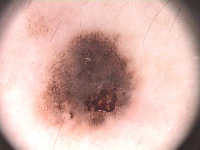</td><td>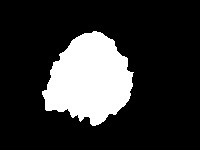</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

- Необходимо максимально зафиксировать весь существующий рандом, чтобы добиться воспроизводимых результатов

In [ ]:
import numpy as np
import torch

import random

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

- Загрузим данные

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. 


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

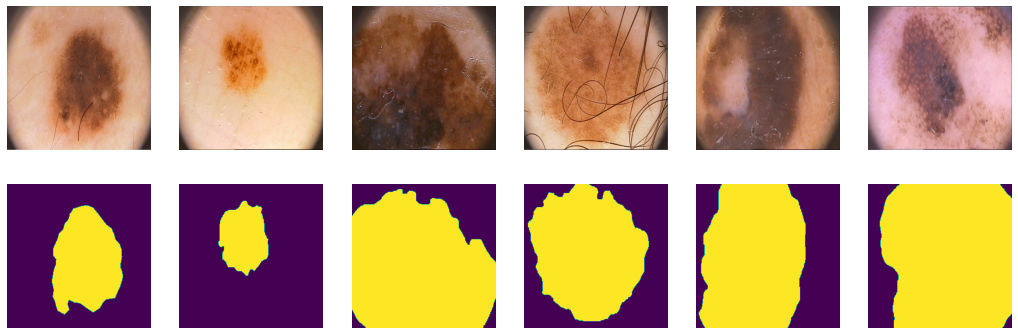

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False) 
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 25
data_train = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True, num_workers=2)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, num_workers=2)
data_test = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet

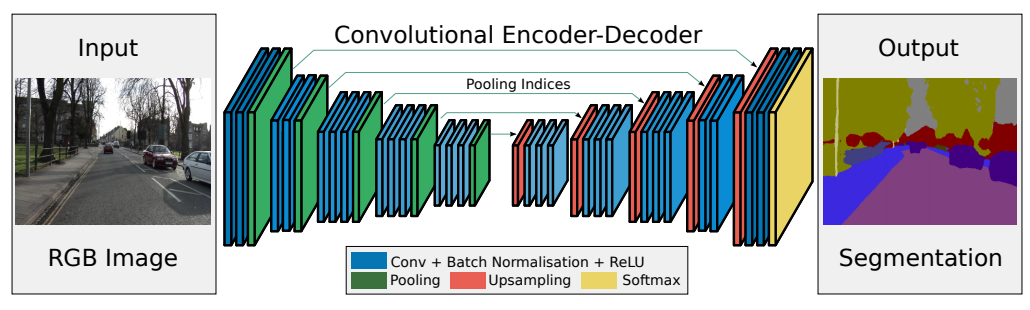

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## encoder

        self.enc_conv0 = self.coder_two_layers(3, 64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)    # 256 -> 128
        self.enc_conv1 = self.coder_two_layers(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)    # 128 -> 64
        self.enc_conv2 = self.coder_three_layers(128,256)
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 64 -> 32
        self.enc_conv3 = self.coder_three_layers(256,512)
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 32 -> 16
        
        ## bottleneck

        self.bottleneck_enc_conv = self.coder_three_layers(512, 512)
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_dec_conv = self.coder_three_layers(512, 512)
        
        ## decoder

        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)                 # 16 -> 32
        self.dec_conv0 = self.coder_three_layers(512,256)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)                 # 32 -> 64
        self.dec_conv1 = self.coder_three_layers(256, 128)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)                 # 64 -> 128
        self.dec_conv2 = self.coder_two_layers(128, 64)

        self.convd31 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bnd31 = nn.BatchNorm2d(64)
        self.convd32 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
      
        e0, index0 = self.pool0(self.enc_conv0(x))
        e1, index1 = self.pool1(self.enc_conv1(e0))
        e2, index2 = self.pool2(self.enc_conv2(e1))
        e3, index3 = self.pool3(self.enc_conv3(e2))

        b0, indexb0 = self.bottleneck_pool(self.bottleneck_enc_conv(e3))
        b1 = self.bottleneck_dec_conv(self.bottleneck_unpool(b0, indexb0))

        d0 = self.dec_conv0(self.upsample0(b1, index3))
        d1 = self.dec_conv1(self.upsample1(d0, index2))
        d2 = self.dec_conv2(self.upsample2(d1, index1))

        d31 = F.max_unpool2d(d2, index0, kernel_size=2, stride=2)
        d32 = F.relu(self.bnd31(self.convd31(d31)))
        d33 = self.convd32(d32)

        return d33

        
    def coder_two_layers(self, in_feature, out_feature):
        layers = nn.Sequential(
                      nn.Conv2d(in_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(out_feature),
                      nn.ReLU(),
                      nn.Conv2d(out_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(out_feature),
                      nn.ReLU()
                    )
        return layers

    def coder_three_layers(self, in_feature, out_feature):
        layers = nn.Sequential(
                      nn.Conv2d(in_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(out_feature),
                      nn.ReLU(),
                      nn.Conv2d(out_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(out_feature),
                      nn.ReLU(),
                      nn.Conv2d(out_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(out_feature),
                      nn.ReLU()
                    )
        return layers

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    SMOOTH = 1e-8

    outputs, labels = outputs.squeeze(1).byte(), labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    return iou

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bse_loss(y_pred, y_real):

    loss = (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

    return loss

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, loss_func, metric, optimizer, scheduler, data_train):

    cnt_train = 0
    sum_train_loss = 0
    sum_train_metric_score = 0

    for X_train, Y_train in data_train:
        X_train, Y_train = X_train.to(device), Y_train.to(device)

        train_metric_score = score_model(model, metric, X_train, Y_train)
        sum_train_metric_score += train_metric_score

        model.train()
        optimizer.zero_grad()
        Y_pred = model(X_train)
        train_loss = loss_func(Y_pred, Y_train)
        train_loss.backward()
        optimizer.step()
        
        sum_train_loss += train_loss.item()
        cnt_train+=1
    scheduler.step()

    print('avg_train_loss:', round(sum_train_loss/cnt_train,3))
    print('avg_train_metric_score:', round(sum_train_metric_score/cnt_train,3))

    return sum_train_loss/cnt_train, sum_train_metric_score/cnt_train

In [ ]:
def validation(model, loss_func, metric, data_val):

    cnt_val = 0
    sum_val_loss = 0
    sum_val_metric_score = 0
    model.eval()

    for X_val, Y_val in data_val:
       
        X_val, Y_val = X_val.to(device), Y_val.to(device)

        val_metric_score = score_model(model, metric, X_val, Y_val)
        sum_val_metric_score += val_metric_score

        with torch.set_grad_enabled(False):
            Y_hat = model(X_val)
            val_loss = loss_func(Y_hat, Y_val)
        sum_val_loss += val_loss.item()
        cnt_val += 1 

    print('avg_val_loss:', round(sum_val_loss/cnt_val,3))
    print('avg_val_metric_score:', round(sum_val_metric_score/cnt_val,3))
  
    return sum_val_loss/cnt_val, sum_val_metric_score/cnt_val

In [ ]:
import time

def fit_epoch(model, loss_func, metric, optimizer, scheduler,
              data_train, data_val, epochs):

    loss_history = []
    metric_history = []
    train_time_epoch = []

    X_example, Y_example = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        start_train_epoch = time.perf_counter()
        avg_train_loss, avg_train_metric_score = train(model, loss_func, metric, optimizer, scheduler, data_train)
        end_train_epoch = time.perf_counter()
        train_time_epoch.append(round(end_train_epoch - start_train_epoch,3))

        avg_val_loss, avg_val_metric_score = validation(model, loss_func, metric, data_val)

        loss_history.append((avg_train_loss, avg_val_loss))
        metric_history.append((avg_train_metric_score, avg_val_metric_score))

        Y_draw = model(X_example.to(device))
        Y_draw = Y_draw.to('cpu').detach().numpy()

        clear_output(wait=True)
        draw(Y_draw, X_example, avg_train_loss, avg_val_loss, avg_train_metric_score, avg_val_metric_score)

    return loss_history, metric_history, train_time_epoch

In [ ]:
def draw(Y_draw, X_example, avg_train_loss, avg_val_loss,
         avg_train_metric_score, avg_val_metric_score):

    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(X_example.to('cpu')[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(Y_draw[k, 0], cmap='gray')
        plt.title('Output_proba')
        plt.axis('off')

        plt.subplot(3, 6, k+13)
        plt.imshow(np.where(Y_draw[k, 0]>=0.5, 1.0, 0.0), cmap='gray')
        plt.title('Output_class')
        plt.axis('off')

    plt.suptitle(f'train_loss = {round(avg_train_loss, 3)}    val_loss = {round(avg_val_loss, 3)}    train_metric = {round(avg_train_metric_score, 3)}    val_metric = {round(avg_val_metric_score, 3)}')
    plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data_test, metric, loss_func):
  
    model.eval()

    cnt_test = 0
    sum_test_loss = 0
    sum_test_metric_score = 0
    for X_test, Y_test in data_test:
       
        X_test, Y_test = X_test.to(device), Y_test.to(device)

        test_metric_score = score_model(model, metric, X_test, Y_test)
        sum_test_metric_score += test_metric_score

        with torch.set_grad_enabled(False):
            Y_pres_test = model(X_test)
            test_loss = loss_func(Y_pres_test, Y_test)
        sum_test_loss += test_loss.item()
        cnt_test += 1 

    print('avg_test_loss:', round(sum_test_loss/cnt_test,3))
    print('avg_test_metric_score:', round(sum_test_metric_score/cnt_test,3))
  
    return sum_test_loss/cnt_test, sum_test_metric_score/cnt_test

In [ ]:
def score_model(model, metric, X_batch, Y_batch):

    model.eval() 
    metric_score = 0
    with torch.set_grad_enabled(False):
        Y_pred = model(X_batch)
        Y_pred = torch.where(Y_pred>0.5, 1.0, 0.0)
    metric_score += metric(Y_pred.to('cpu'), Y_batch.to('cpu')).mean().item()

    return metric_score

- Функции для отрисовки результатов

In [ ]:
def draw_loss(loss_history, text_title = 'Loss-динамика'):
  
    train_loss, val_loss = zip(*loss_history)

    plt.figure(figsize=(15, 9))
    plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
    plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
    plt.grid(True, alpha=0.7)
    plt.ylim([0, 1.1*max([max(i) for i in loss_history])])

    plt.plot(
        train_loss, label='train_loss', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_loss, label='val_loss', linewidth=4, 
        color='green', linestyle='--', alpha=0.75
    )
    plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
    )
    plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
    )
    plt.ylabel(
        'Loss', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
    )
    plt.title(
        text_title,fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
    )
    plt.show()

In [ ]:
def draw_metric(metric_history, text_title = 'Loss-динамика'):
  
    train_metric, val_metric = zip(*metric_history)

    plt.figure(figsize=(15, 9))
    plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
    plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
    plt.grid(True, alpha=0.7)
    plt.ylim([0, 1.1*max([max(i) for i in metric_history])])

    plt.plot(
        train_metric, label='train_metric', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric', linewidth=4, 
        color='green', linestyle='--', alpha=0.75
    )
    plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
    )
    plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
    )
    plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
    )
    plt.title(
        text_title,fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
    )
    plt.show()

- Функции для сохранения результатов

In [ ]:
import pandas as pd

def save_loss(loss, path):
    
    df_loss = pd.DataFrame(loss)
    df_loss.to_pickle(path)

def save_metric(metric, path):
    
    df_metric = pd.DataFrame(metric)
    df_metric.to_pickle(path)

def save_time_train(time, path):

    df_time = pd.DataFrame(time)
    df_time.to_pickle(path)

## Основной момент: обучение


In [ ]:
model_bse = SegNet()
model_bse.to(device)

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0)

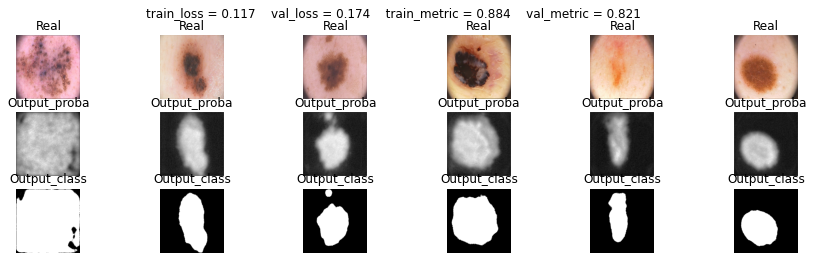

In [ ]:
from torch.optim import lr_scheduler

loss_func = bse_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_bse.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_bse, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_bse.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_time_train_e50')

- Загрузка результатов

In [ ]:
model_bse = SegNet()
model_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_e50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
bse_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_loss_e50')
bse_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_metric_e50')
bse_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_time_train_e50')

- Отрисовка результатов

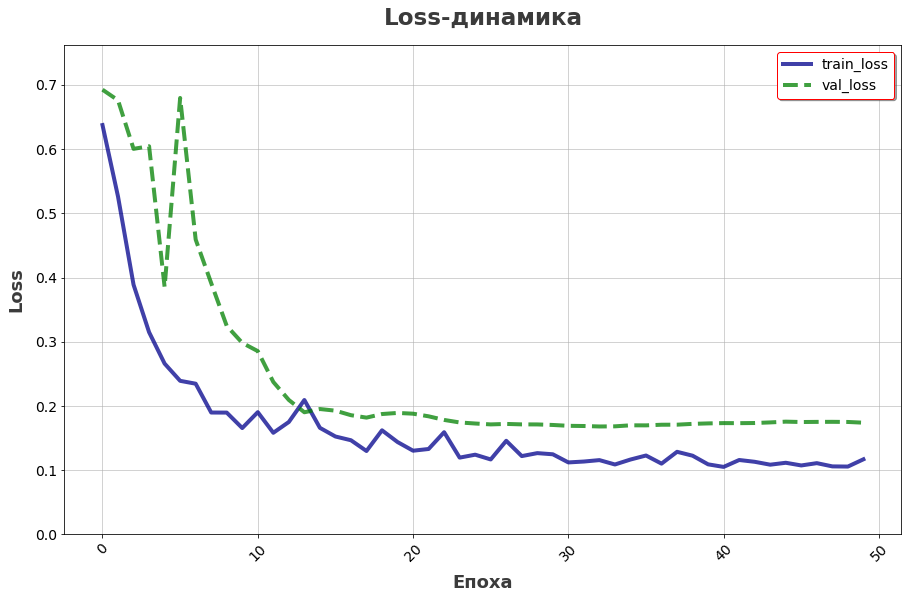

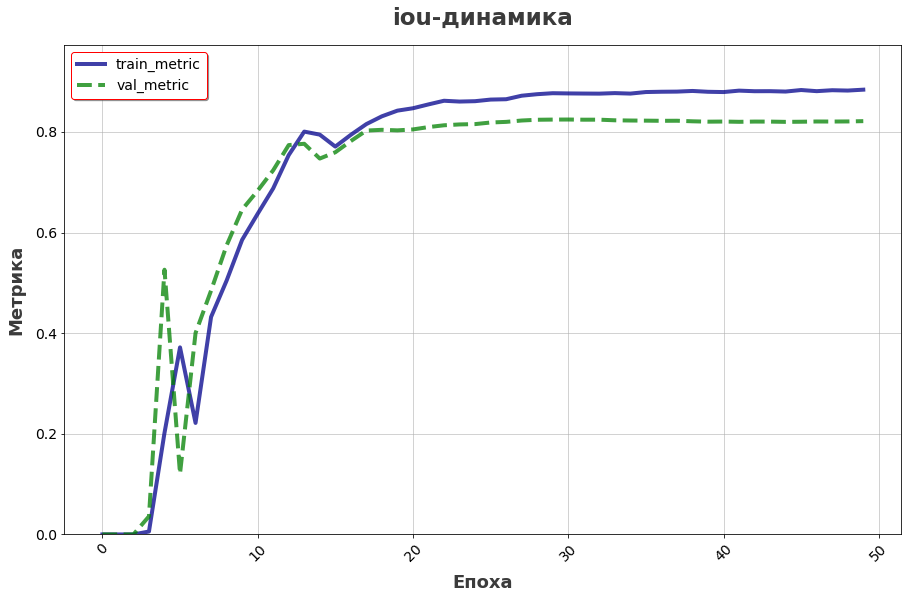

In [ ]:
draw_loss(bse_segnet_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(bse_segnet_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- Переобучается ли модель?**

Из графиков выше сложно сказать переобучается модель или нет. Попробуем изменить масштаб и приблизить некоторые участки

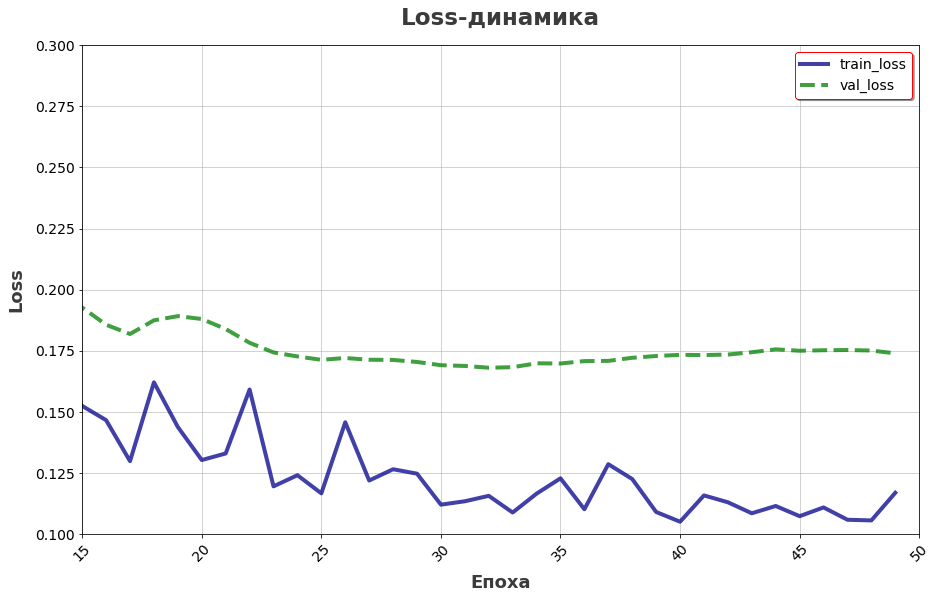

In [ ]:
loss_history = bse_segnet_loss_e50.to_numpy()

train_loss, val_loss = zip(*loss_history)

plt.figure(figsize=(15, 9))
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)
plt.ylim([0.1, 0.3])
plt.xlim([15, 50])

plt.plot(
        train_loss, label='train_loss', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
) 
plt.plot(
        val_loss, label='val_loss', linewidth=4, 
        color='green', linestyle='--', alpha=0.75
)
plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Loss', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
         'Loss-динамика', fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

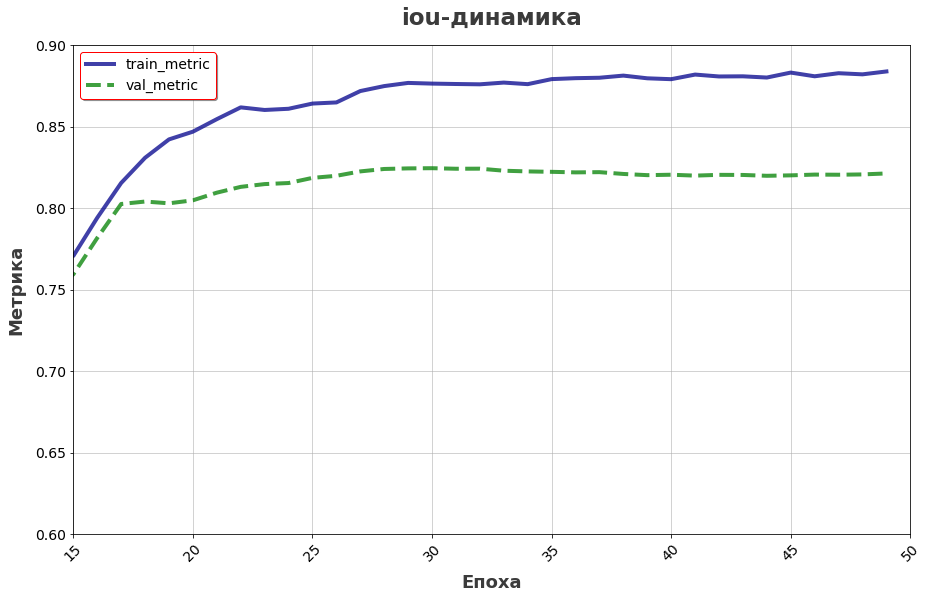

In [ ]:
metric_history = bse_segnet_metric_e50.to_numpy()

train_metric, val_metric = zip(*metric_history)

plt.figure(figsize=(15, 9))
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)
plt.ylim([0.6, 0.9])
plt.xlim([15, 50])

plt.plot(
        train_metric, label='train_metric', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
) 
plt.plot(
        val_metric, label='val_metric', linewidth=4, 
        color='green', linestyle='--', alpha=0.75
)
plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

**Ответ:**

**Даже в таком масштабе сложно сказать переобучается ли модель. Так как после 30 эпохи val_loss начинает расти, а train_loss падать, но на 45 эпохи val_loss стабилизируется. Скорее всего нужно больше эпох обучать модель, чтобы сказать переобучается она или нет. На тех результатах которые у меня получились, можно сказать, что модель не переобучается, даже если и переобучается то незначительно**

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [ ]:
def dice_loss(y_pred, y_real, eps=1e-8):

    smooth = eps

    y_pred = F.sigmoid(y_pred)       
    y_pred, y_real = y_pred.view(-1), y_real.view(-1)

    num = (y_pred * y_real).sum()
    den = y_pred.sum() + y_real.sum()
    res = 1 - (2.0*num + smooth)/(den + smooth)  
        
    return res

Проводим тестирование:

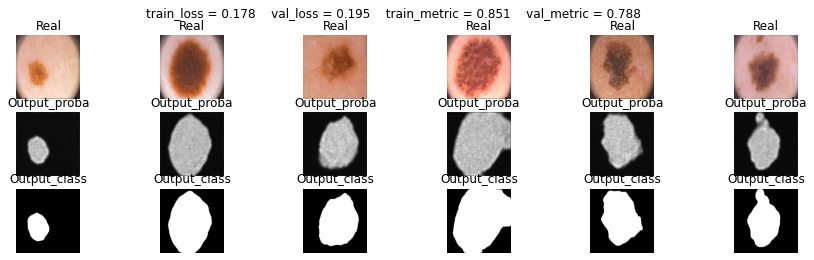

In [ ]:
from torch.optim import lr_scheduler

model_dice = SegNet().to(device)

loss_func = dice_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_dice.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_dice, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_dice.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_time_train_e50')

- Загрузка результатов

In [ ]:
model_dice = SegNet().to(device)
model_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_e50.pth'))


<All keys matched successfully>

In [ ]:
dice_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_loss_e50')
dice_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_metric_e50')
dice_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_time_train_e50')

- Отрисовка результатов

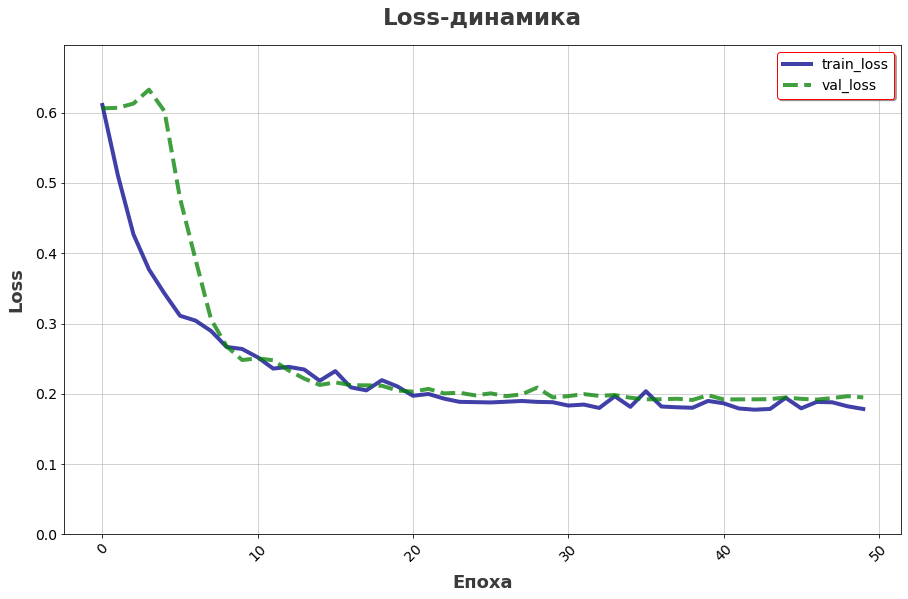

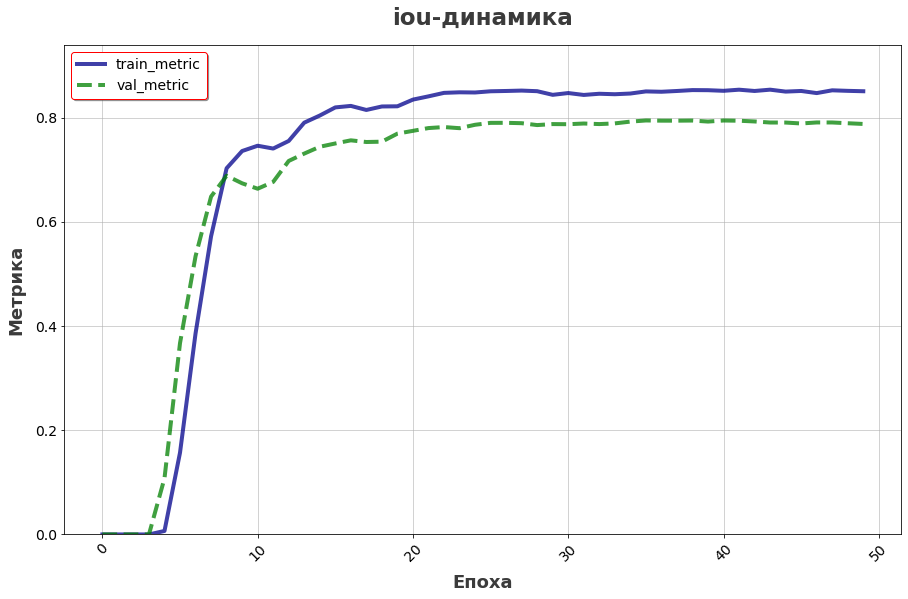

In [ ]:
draw_loss(dice_segnet_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(dice_segnet_metric_e50.to_numpy(), text_title = 'iou-динамика')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, gamma = 2):
    smooth = 10e-8
    sig_y_pred = F.sigmoid(y_pred) 
    loss = -((1 - sig_y_pred)**gamma * (y_real* torch.log(sig_y_pred+smooth)) + (sig_y_pred)**gamma * (1 - y_real)*torch.log(1 - sig_y_pred+smooth)).mean()
    
    return loss

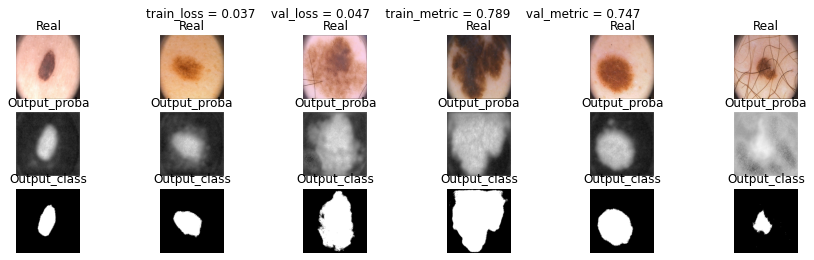

In [ ]:
from torch.optim import lr_scheduler

model_focal = SegNet().to(device)

loss_func = focal_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_focal.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_focal, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_focal.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_time_train_e50')

- Загрузка результатов

In [ ]:
model_focal = SegNet().to(device)
model_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_e50.pth'))


<All keys matched successfully>

In [ ]:
focal_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_loss_e50')
focal_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_metric_e50')
focal_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_time_train_e50')

- Отрисовка результатов

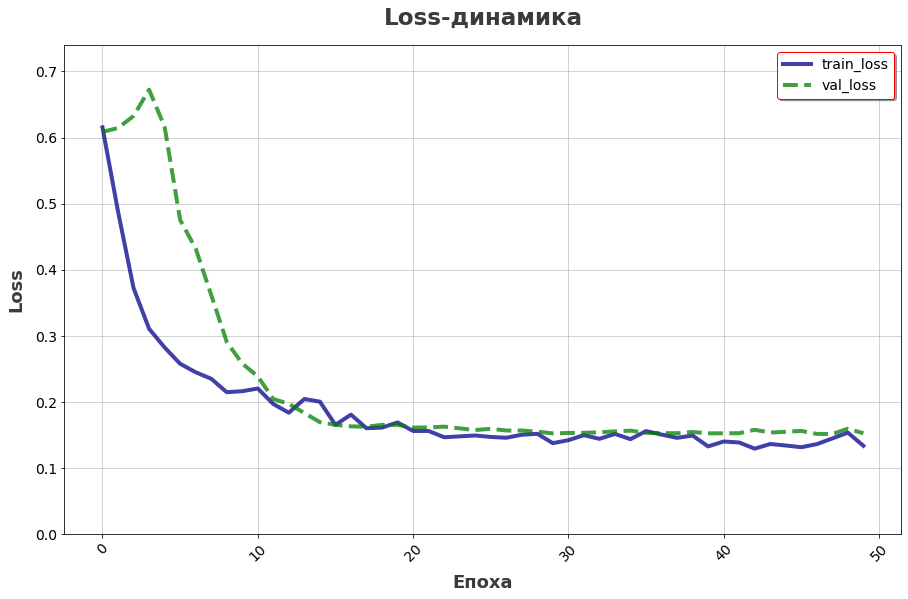

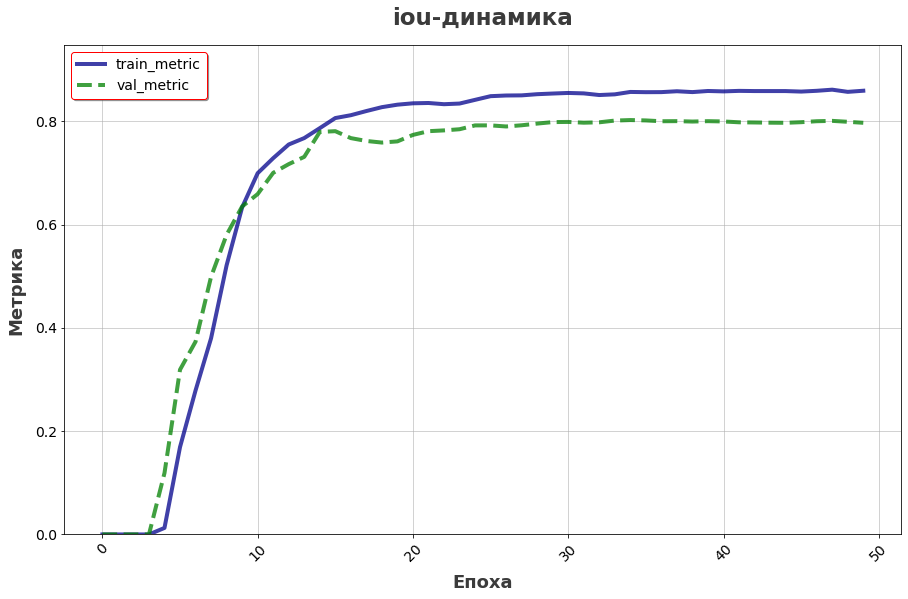

In [ ]:
draw_loss(focal_segnet_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(focal_segnet_metric_e50.to_numpy(), text_title = 'iou-динамика')

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов

В данном блоке напишем  Lovasz_loss

- Реализуем lovasz_loss ниже

In [ ]:
def lovasz_loss(y_pred, y_real):

    losses = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.permute(0, 2, 3, 1).contiguous().view(-1)  
    y_real = y_real.view(-1)  
    loss = (torch.autograd.Variable(y_real) - y_pred).abs()
    loss_sort, loss_index = torch.sort(loss, 0, descending=True)
    y_real_sort = y_real[loss_index]    

    sum_real_sort = y_real_sort.sum()
    intersection = sum_real_sort - y_real_sort.float().cumsum(0)
    union = sum_real_sort + (1 - y_real_sort).float().cumsum(0)
    jaccard = 1 - intersection / union
    
    if len(y_real_sort) > 1:
        jaccard[1:len(y_real_sort)] = jaccard[1:len(y_real_sort)] - jaccard[0:-1]

    losses.append(torch.dot(loss_sort, jaccard))
    losses = torch.stack(losses)

    return losses.mean()

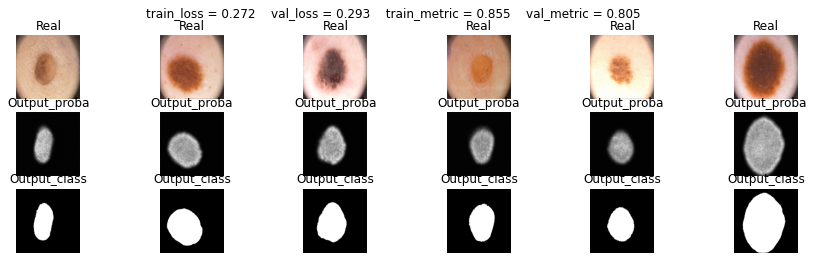

In [ ]:
from torch.optim import lr_scheduler

model_lovasz = SegNet().to(device)

loss_func = lovasz_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_lovasz.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_lovasz, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_lovasz.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_time_train_e50')

- Загрузка результатов

In [ ]:
model_lovasz = SegNet().to(device)
model_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_e50.pth'))

<All keys matched successfully>

In [ ]:
lovasz_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_loss_e50')
lovasz_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_metric_e50')
lovasz_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_time_train_e50')

- Отрисовка результатов

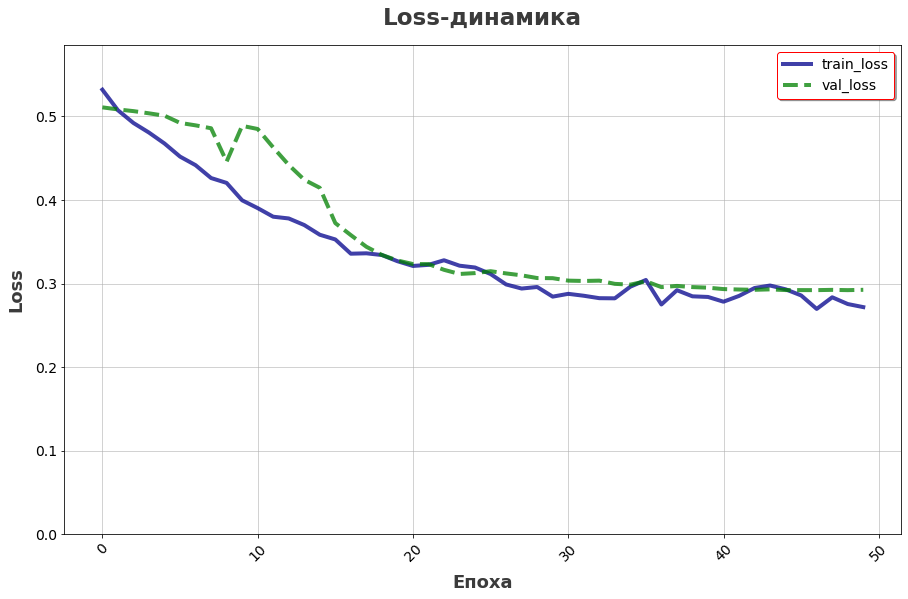

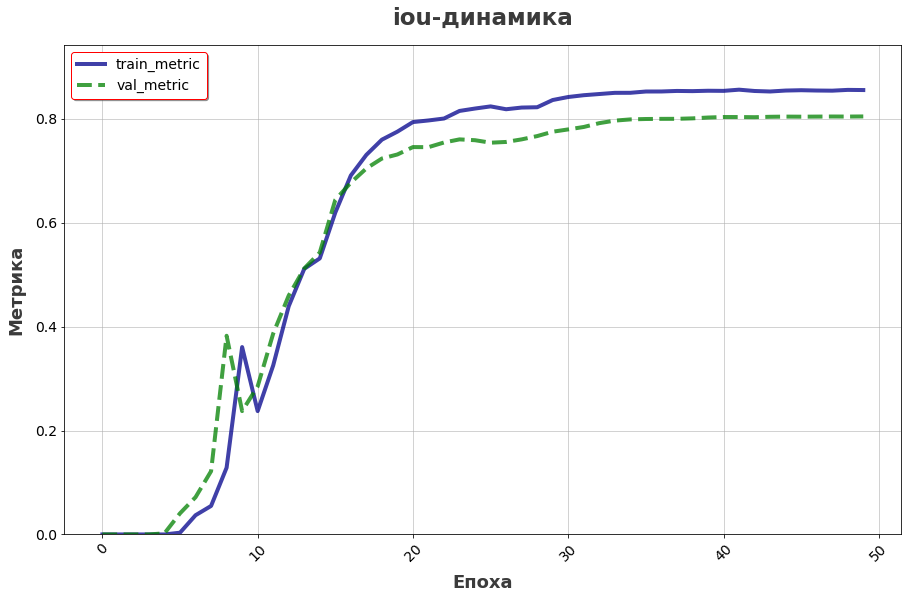

In [ ]:
draw_loss(lovasz_segnet_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(lovasz_segnet_metric_e50.to_numpy(), text_title = 'iou-динамика')

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

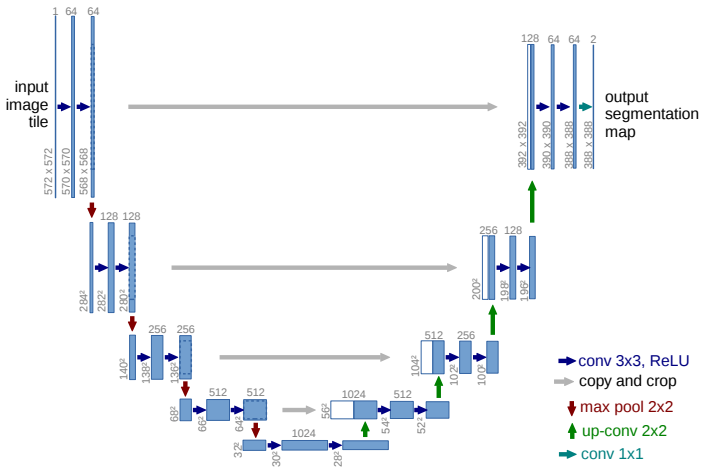

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.enc_conv0 = self.layers(3, 64)
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = self.layers(64, 128)
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = self.layers(128, 256)
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = self.layers(256, 512)
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv = self.layers_up(512, 1024, 512)

        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = self.layers_up(1024, 512, 256)
        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = self.layers_up(512, 256, 128)
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = self.layers_up(256, 128, 64)
        self.upsample3 = nn.Upsample(256)
        self.dec_conv3 = self.layers(128, 64)

        self.conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        b = self.bottleneck_conv(self.pool3(e3))

        d0 = self.upsample0(b)
        d0 = torch.cat((d0, e3), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0), dim=1)
        d3 = self.dec_conv3(d3)
        
        return self.conv(d3)

    def layers(self, in_feature, out_feature):

        layer = nn.Sequential(
                    nn.Conv2d(in_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(out_feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(out_feature),
                    nn.ReLU(inplace=True)
        )

        return layer

    def layers_up(self, in_feature, mid_feature, out_feature):

        layer = nn.Sequential(
                    nn.Conv2d(in_feature, mid_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(mid_feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(mid_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(out_feature),
                    nn.ReLU(inplace=True)
        )

        return layer

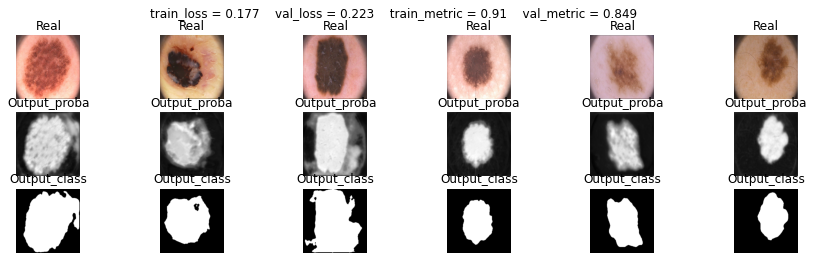

In [ ]:
from torch.optim import lr_scheduler

model_unet_bse = UNet().to(device)

loss_func = bse_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet_bse.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet_bse, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet_bse.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet_bse = UNet().to(device)
model_unet_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_e50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
unet_bse_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_loss_e50')
unet_bse_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_metric_e50')
unet_bse_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_time_train_e50')

- Отрисовка результатов

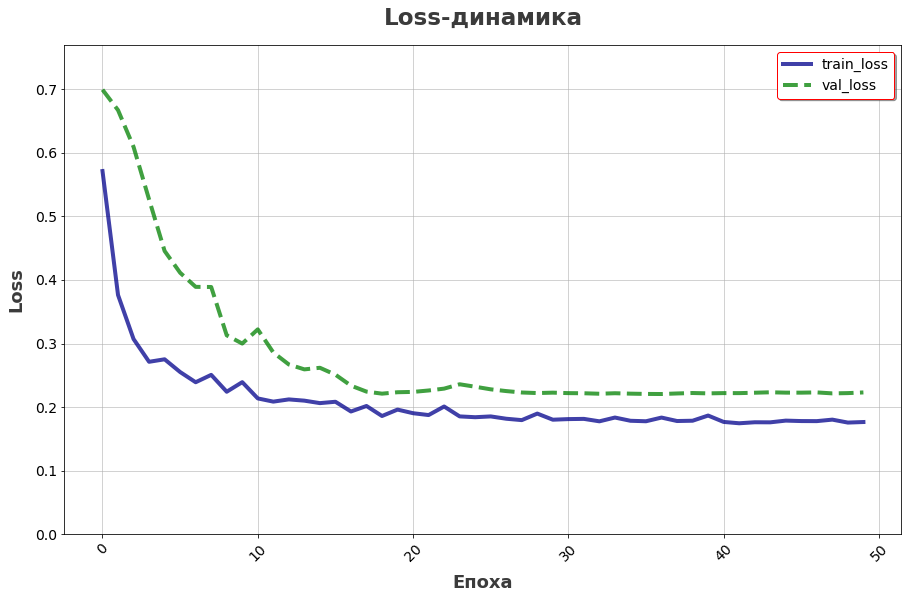

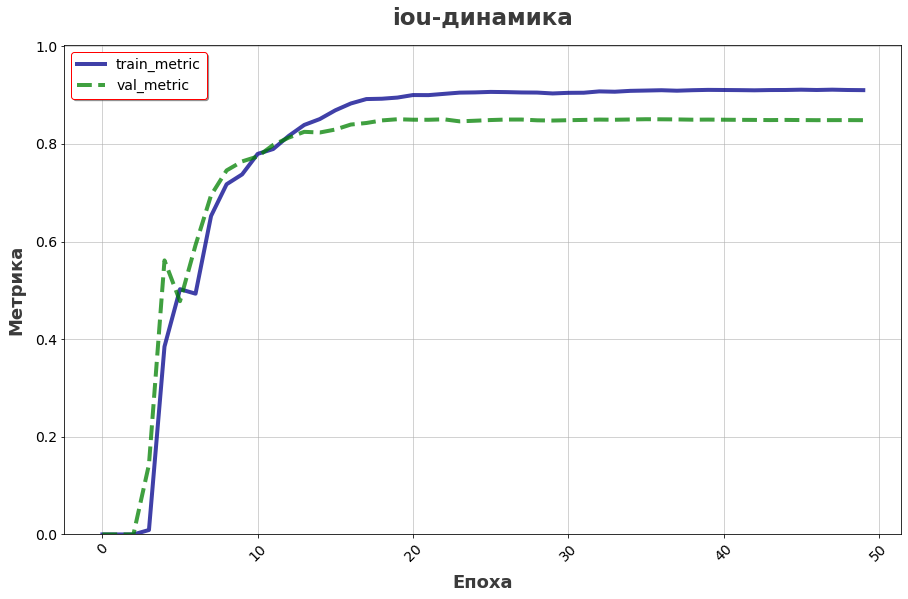

In [ ]:
draw_loss(unet_bse_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet_bse_metric_e50.to_numpy(), text_title = 'iou-динамика')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        self.enc_conv0 = self.layers(3, 64)
        self.pool0 =  nn.Conv2d(64, 64, kernel_size=2, stride=2)
        self.enc_conv1 = self.layers(64, 128)
        self.pool1 =  nn.Conv2d(128, 128, kernel_size=2, stride=2)
        self.enc_conv2 = self.layers(128, 256)
        self.pool2 =  nn.Conv2d(256, 256, kernel_size=2, stride=2)
        self.enc_conv3 = self.layers(256, 512)
        self.pool3 =  nn.Conv2d(512, 512, kernel_size=2, stride=2)

        self.bottleneck_conv = self.layers(512, 1024)

        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv0 = self.layers(1024, 512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = self.layers(512, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.layers(256, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = self.layers(128, 64)

        self.conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):

        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        b = self.bottleneck_conv(self.pool3(e3))

        d0 = self.upsample0(b)
        d0 = torch.cat((d0, e3), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0), dim=1)
        d3 = self.dec_conv3(d3)
        
        return self.conv(d3)

    def layers(self, in_feature, out_feature):

        layer = nn.Sequential(
                    nn.Conv2d(in_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(out_feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_feature, out_feature, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(out_feature),
                    nn.ReLU(inplace=True)
        )


        return layer

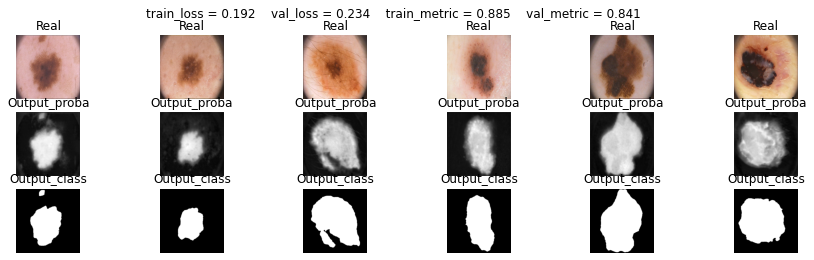

In [ ]:
from torch.optim import lr_scheduler

model_unet2_bse = UNet2().to(device)

loss_func = bse_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet2_bse.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch( 
    model_unet2_bse, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet2_bse.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet2_bse = UNet2().to(device)
model_unet2_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_e50.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
unet2_bse_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_loss_e50')
unet2_bse_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_metric_e50')
unet2_bse_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_time_train_e50')

- Отрисовка результатов

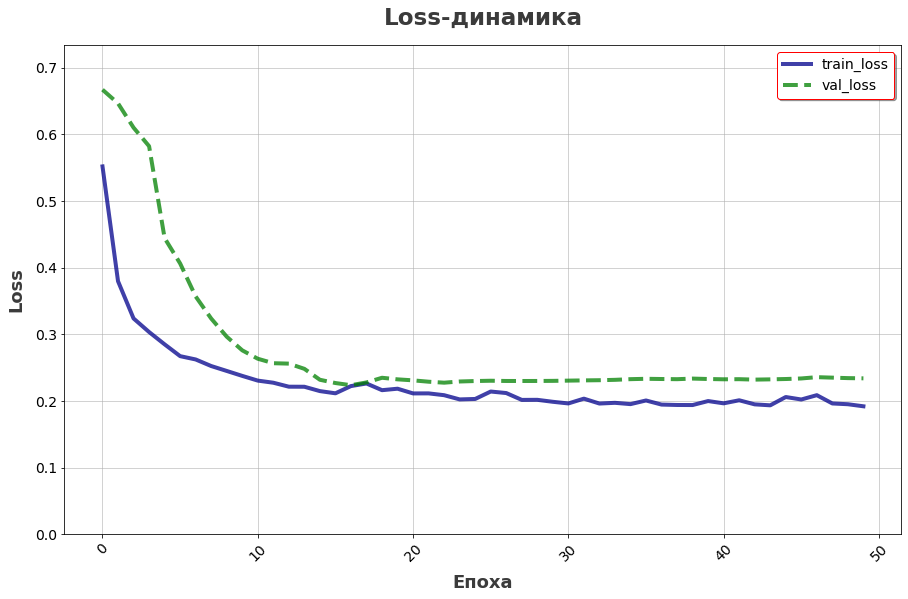

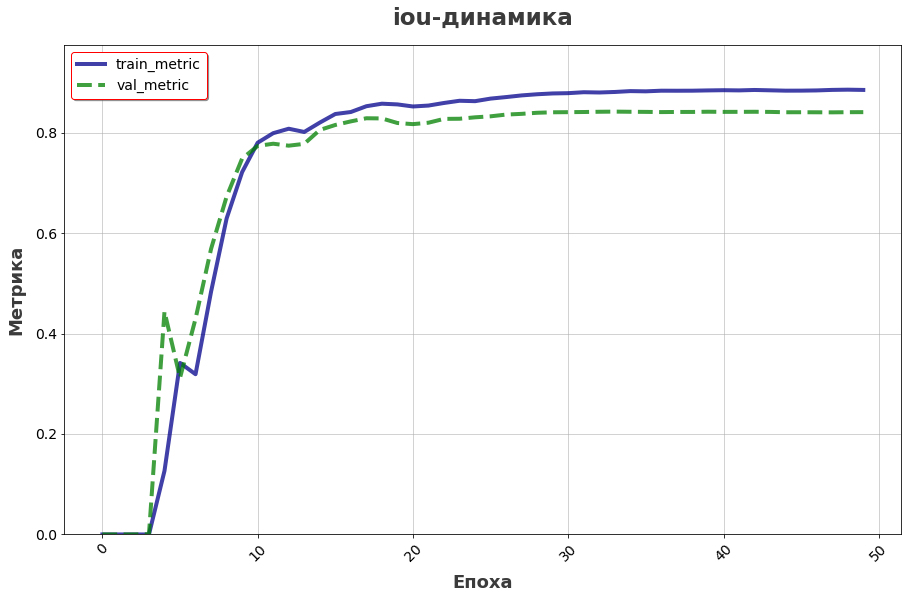

In [ ]:
draw_loss(unet2_bse_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet2_bse_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- Вывод**

Сделайте вывод, какая из моделей лучше

- Давайте построим на одном графики метрики по обоим моделям

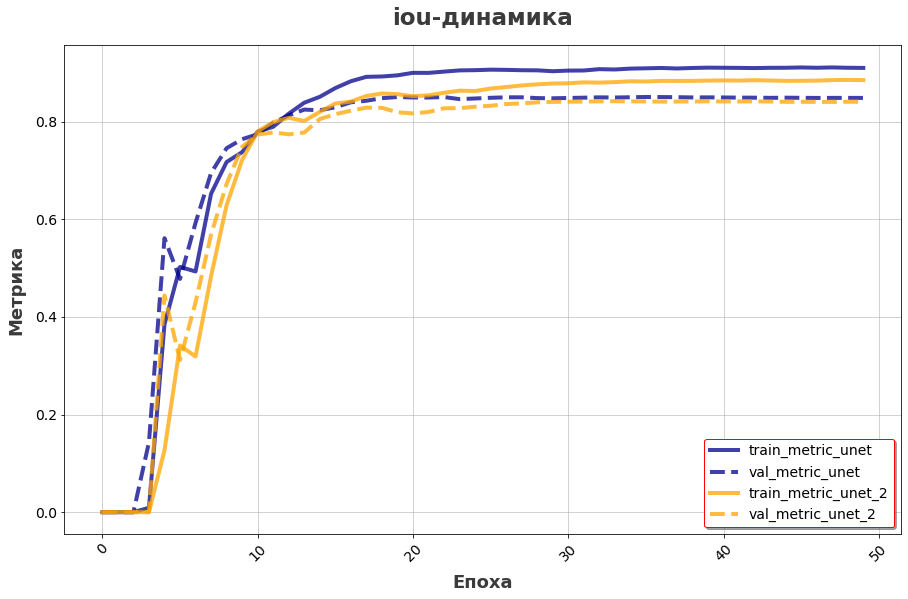

In [ ]:
metric_history_unet = unet_bse_metric_e50.to_numpy()
metric_history_unet2 = unet2_bse_metric_e50.to_numpy()

train_metric_unet, val_metric_unet = zip(*metric_history_unet)
train_metric_unet2, val_metric_unet2 = zip(*metric_history_unet2)

plt.figure(figsize=(15, 9))
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)

plt.plot(
        train_metric_unet, label='train_metric_unet', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
) 
plt.plot(
        val_metric_unet, label='val_metric_unet', linewidth=4, 
        color='darkblue', linestyle='--', alpha=0.75
)
plt.plot(
        train_metric_unet2, label='train_metric_unet_2', linewidth=4, 
        color='orange', linestyle='-', alpha=0.75
) 
plt.plot(
        val_metric_unet2, label='val_metric_unet_2', linewidth=4, 
        color='orange', linestyle='--', alpha=0.75
)
plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Из данного графика не совсем понятно, какая модель лучше по метрике iou. Давайте изменим масштаб и посмотрим на отдельный участок

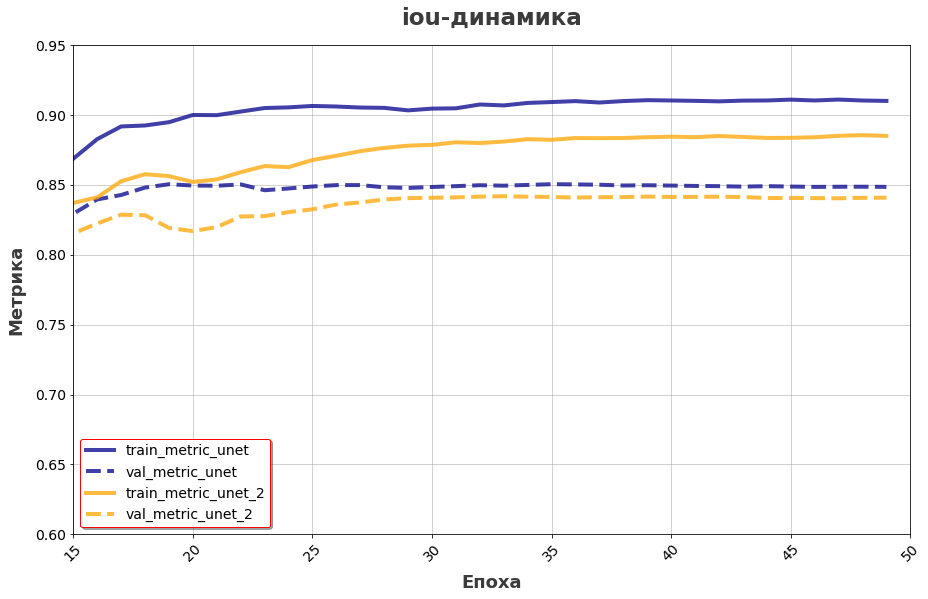

In [ ]:
metric_history_unet = unet_bse_metric_e50.to_numpy()
metric_history_unet2 = unet2_bse_metric_e50.to_numpy()

train_metric_unet, val_metric_unet = zip(*metric_history_unet)
train_metric_unet2, val_metric_unet2 = zip(*metric_history_unet2)

plt.figure(figsize=(15, 9))
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)
plt.xlim([15, 50])
plt.ylim([0.6, 0.95])
plt.plot(
        train_metric_unet, label='train_metric_unet', linewidth=4, 
        color='darkblue', linestyle='-', alpha=0.75
) 
plt.plot(
        val_metric_unet, label='val_metric_unet', linewidth=4, 
        color='darkblue', linestyle='--', alpha=0.75
)
plt.plot(
        train_metric_unet2, label='train_metric_unet_2', linewidth=4, 
        color='orange', linestyle='-', alpha=0.75
) 
plt.plot(
        val_metric_unet2, label='val_metric_unet_2', linewidth=4, 
        color='orange', linestyle='--', alpha=0.75
)
plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Из графика видно, что модель UNet лучше модели UNet2 по метрике iou как на трейновой так и на валидационной выборке

- Сравним среднее время обучения на одну эпоху

In [ ]:
print('Модель UNet. Среднее время обучения на одну эпоху: ', round(unet_bse_time_train_e50.to_numpy().mean(),2))
print('Модель UNet2. Среднее время обучения на одну эпоху: ', round(unet2_bse_time_train_e50.to_numpy().mean(),2))

Модель UNet. Среднее время обучения на одну эпоху:  29.93
Модель UNet2. Среднее время обучения на одну эпоху:  37.71


Модель UNet обучается быстрее модели UNet2



- Проверим модели на тестовой выборке

In [ ]:
predict(model_unet2_bse, data_test, iou_pytorch, bse_loss)

None

avg_test_loss: 0.217
avg_test_metric_score: 0.867


In [ ]:
predict(model_unet_bse, data_test, iou_pytorch, bse_loss)

None

avg_test_loss: 0.207
avg_test_metric_score: 0.876


Наилучшие метрики на тестовой выборке показала модель UNet

**Ответ: Модель UNet превосходит по всем параметрам модель UNet2. Модель UNet лучше**

## Unet обучение с другими функциями потерь

Для реализации отчета обучим модель UNet и UNet2 на лоссах focal, dice и lovasz

**- Unet c dice_loss**

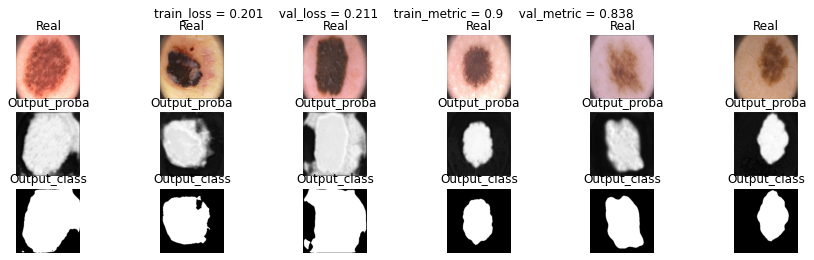

In [ ]:
from torch.optim import lr_scheduler

model_unet_dice = UNet().to(device)

loss_func = dice_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet_dice.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet_dice, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet_dice.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet_dice = UNet().to(device)
model_unet_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_e50.pth'))


<All keys matched successfully>

In [ ]:
unet_dice_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_loss_e50')
unet_dice_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_metric_e50')
unet_dice_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_time_train_e50')

- Отрисовка результатов

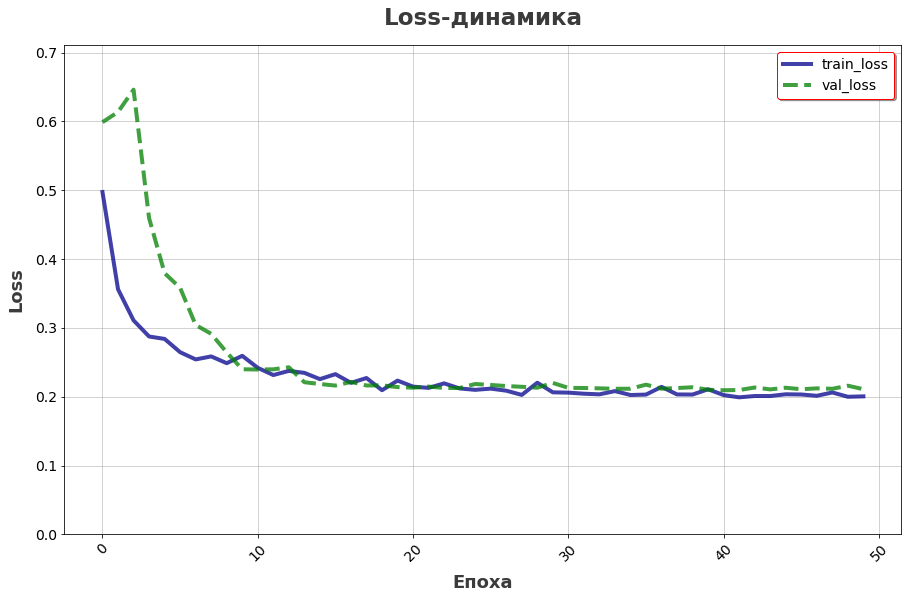

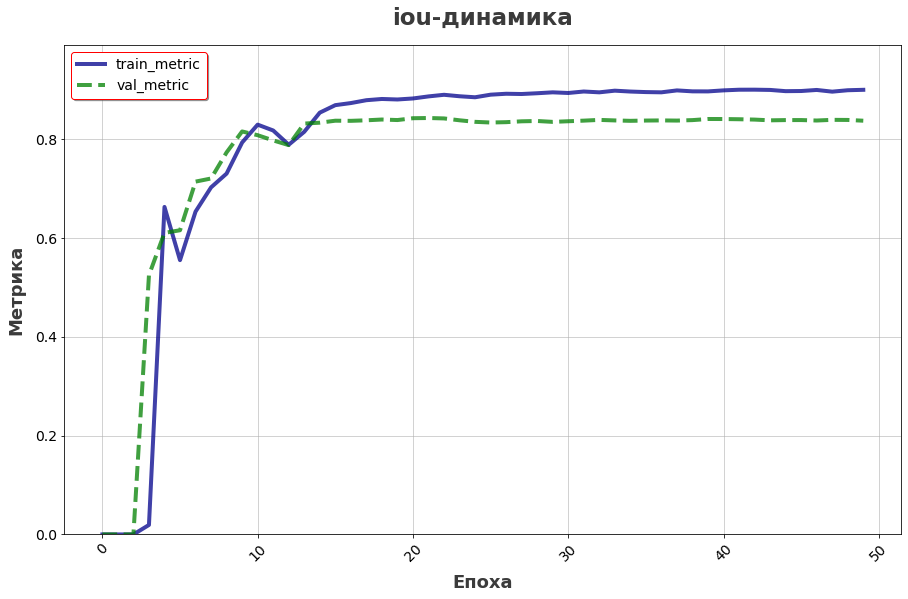

In [ ]:
draw_loss(unet_dice_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet_dice_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- Unet c focal_loss**

In [ ]:
from torch.optim import lr_scheduler

model_unet_focal = UNet().to(device)

loss_func = focal_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet_focal.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet_focal, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet_focal.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet_focal = UNet().to(device)
model_unet_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_e50.pth'))


<All keys matched successfully>

In [ ]:
unet_focal_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_loss_e50')
unet_focal_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_metric_e50')
unet_focal_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_time_train_e50')

- Отрисовка результатов

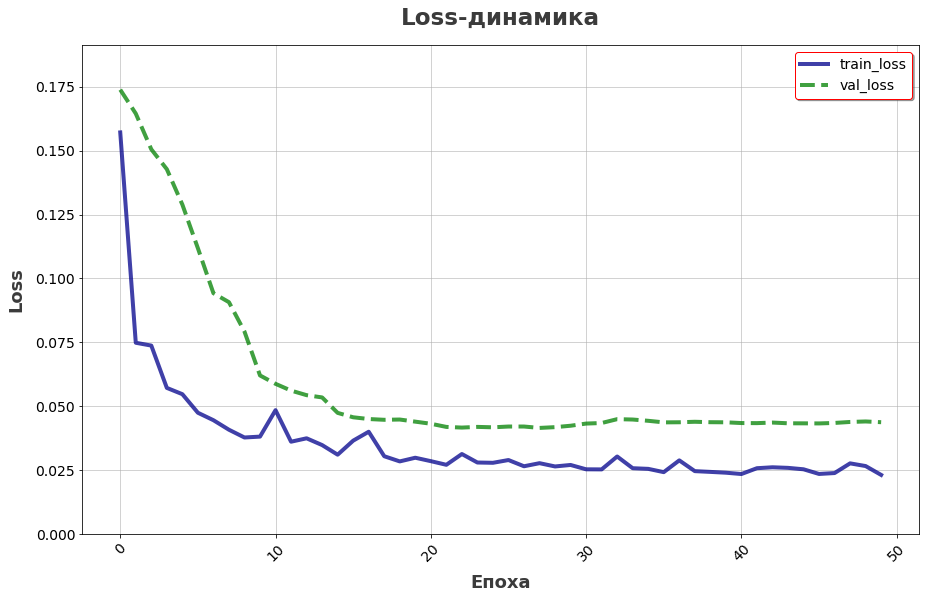

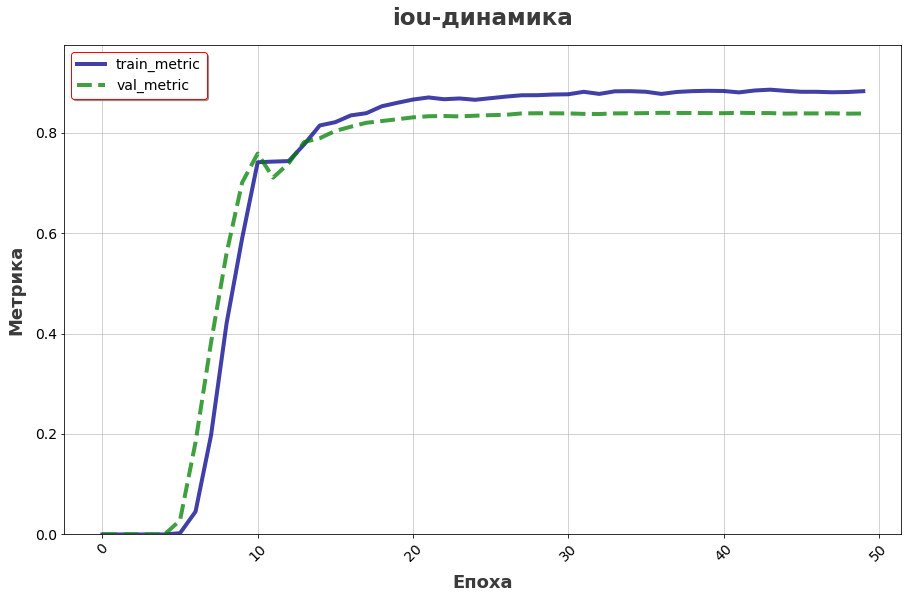

In [ ]:
draw_loss(unet_focal_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet_focal_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- Unet c lovasz_loss**

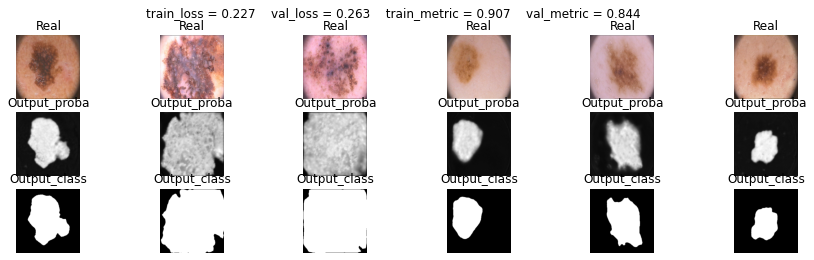

In [ ]:
from torch.optim import lr_scheduler

model_unet_lovasz = UNet().to(device)

loss_func = lovasz_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet_lovasz.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet_lovasz, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet_lovasz.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet_lovasz = UNet().to(device)
model_unet_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_e50.pth'))

<All keys matched successfully>

In [ ]:
unet_lovasz_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_loss_e50')
unet_lovasz_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_metric_e50')
unet_lovasz_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_time_train_e50')

- Отрисовка результатов

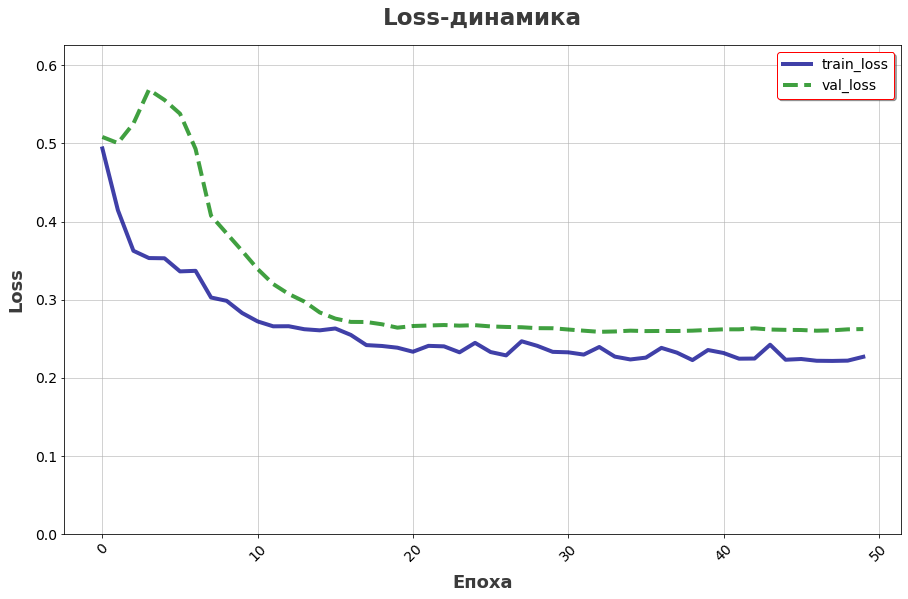

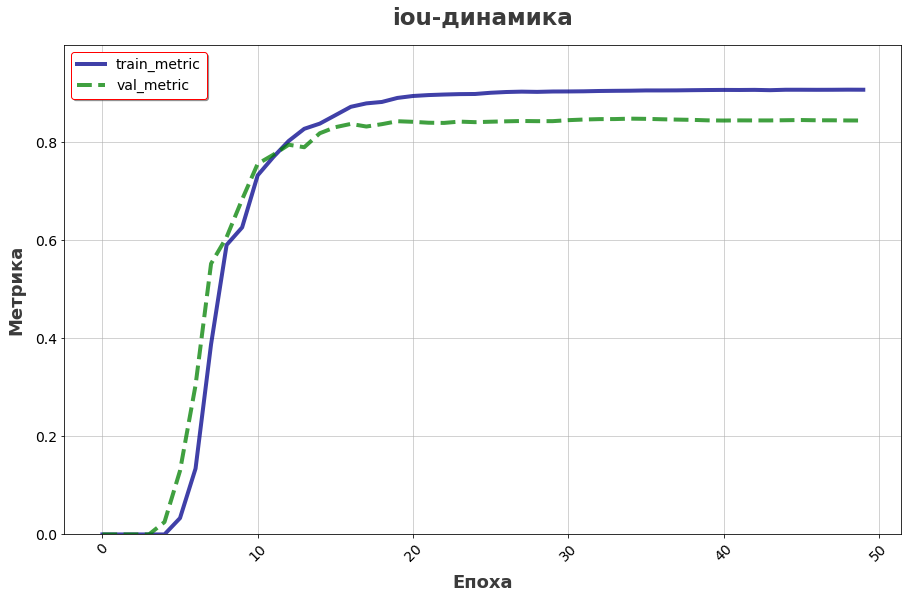

In [ ]:
draw_loss(unet_lovasz_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet_lovasz_metric_e50.to_numpy(), text_title = 'iou-динамика')

## Unet2 обучение с другими функциями потерь

**- UNet2 c dice_loss**

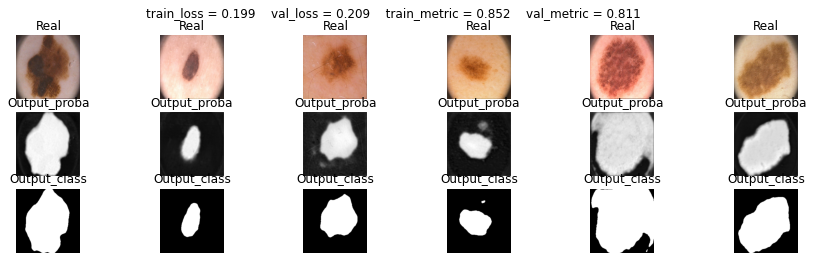

In [ ]:
from torch.optim import lr_scheduler

model_unet2_dice = UNet2().to(device)

loss_func = dice_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet2_dice.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet2_dice, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet2_dice.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet2_dice = UNet2().to(device)
model_unet2_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_e50.pth'))

<All keys matched successfully>

In [ ]:
unet2_dice_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_loss_e50')
unet2_dice_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_metric_e50')
unet2_dice_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_time_train_e50')

- Отрисовка результатов

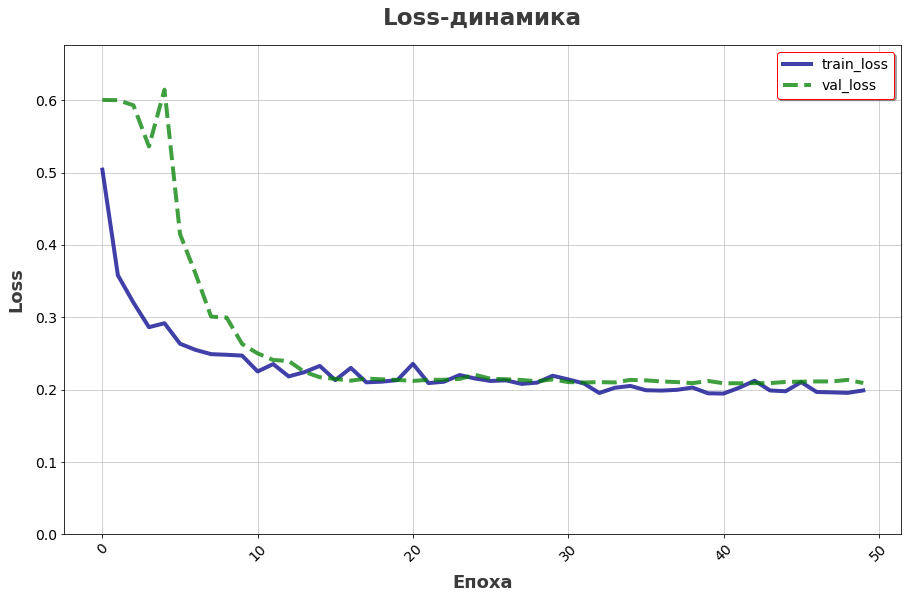

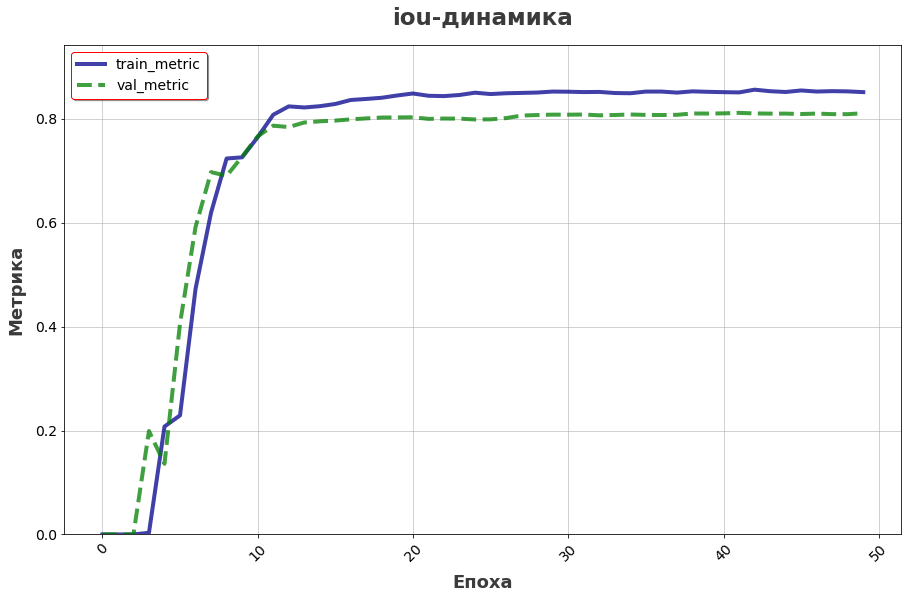

In [ ]:
draw_loss(unet2_dice_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet2_dice_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- UNet2 c focal_loss**

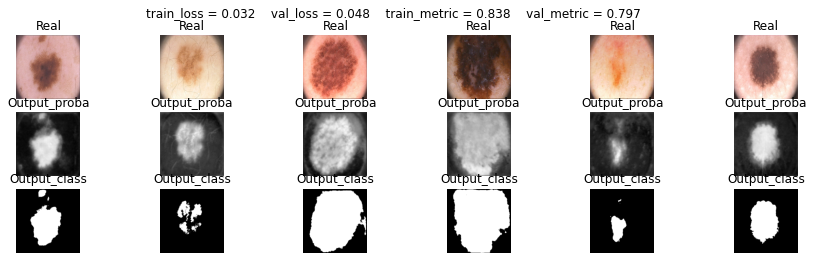

In [ ]:
from torch.optim import lr_scheduler

model_unet2_focal = UNet2().to(device)

loss_func = focal_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet2_focal.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet2_focal, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet2_focal.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet2_focal = UNet2().to(device)
model_unet2_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_e50.pth'))

<All keys matched successfully>

In [ ]:
unet2_focal_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_loss_e50')
unet2_focal_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_metric_e50')
unet2_focal_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_time_train_e50')

- Отрисовка результатов

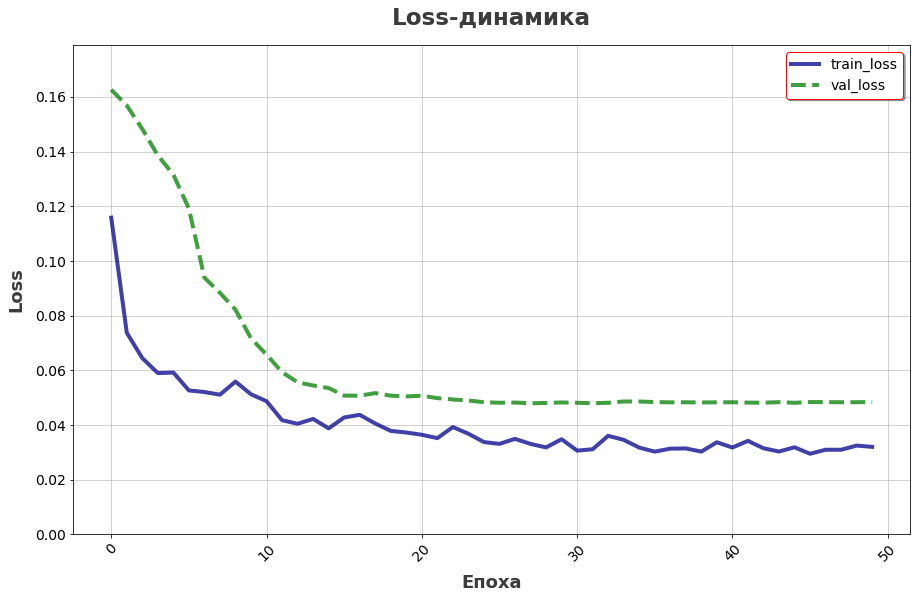

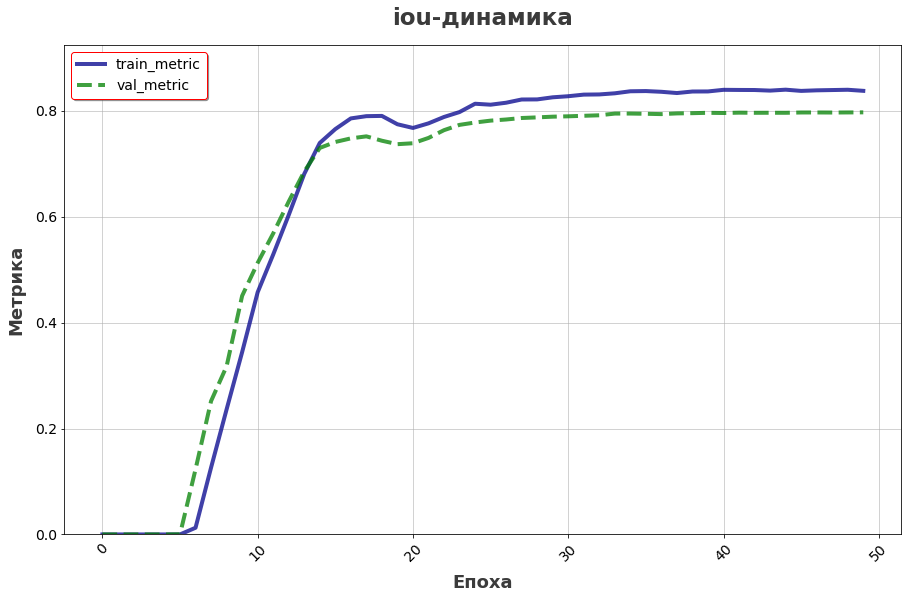

In [ ]:
draw_loss(unet2_focal_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet2_focal_metric_e50.to_numpy(), text_title = 'iou-динамика')

**- UNet2 c lovasz_loss**

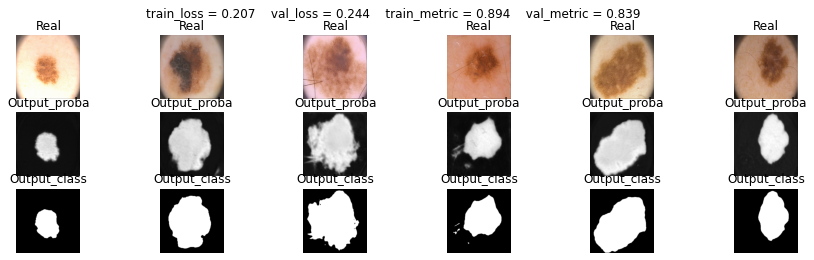

In [ ]:
from torch.optim import lr_scheduler

model_unet2_lovasz = UNet2().to(device)

loss_func = lovasz_loss
metric = iou_pytorch

optimizer = torch.optim.Adam(model_unet2_lovasz.parameters(), lr=3*1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50

loss_history, metric_history, train_time = fit_epoch(
    model_unet2_lovasz, loss_func, metric, optimizer, scheduler,
    data_train, data_val, epochs
)

- Сохранение результатов

In [ ]:
# torch.save(model_unet2_lovasz.state_dict(), '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_e50.pth')
# save_loss(loss_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_loss_e50')
# save_metric(metric_history, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_metric_e50')
# save_time_train(train_time, '/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_time_train_e50')

- Загрузка результатов

In [ ]:
model_unet2_lovasz = UNet2().to(device)
model_unet2_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_e50.pth'))

<All keys matched successfully>

In [ ]:
unet2_lovasz_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_loss_e50')
unet2_lovasz_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_metric_e50')
unet2_lovasz_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_time_train_e50')

- Отрисовка результатов

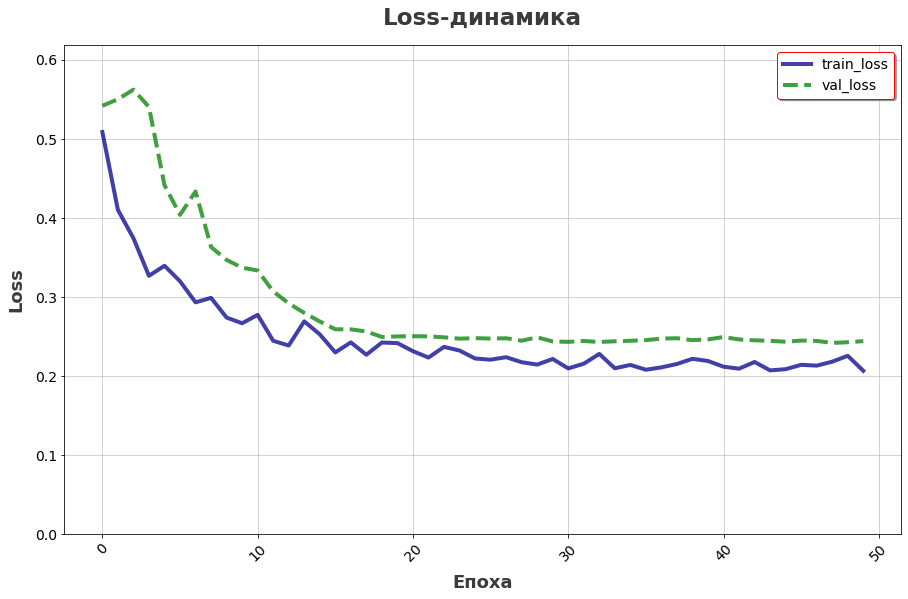

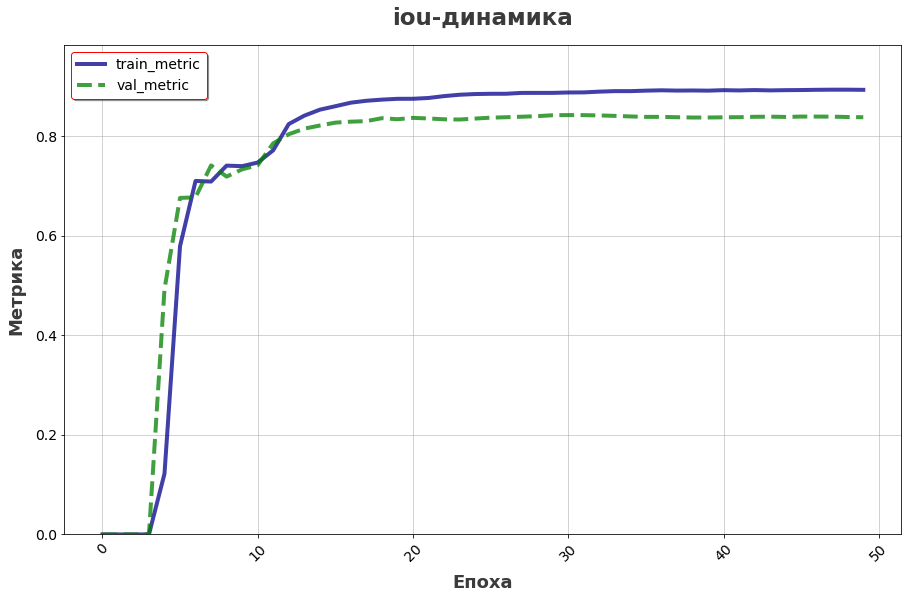

In [ ]:
draw_loss(unet2_lovasz_loss_e50.to_numpy(), text_title = 'Loss-динамика')
draw_metric(unet2_lovasz_metric_e50.to_numpy(), text_title = 'iou-динамика')

# Отчет

## Введение

В работе было реализовано три архетектуры нейросети для решения задачи сегментации: SegNet, UNet, UNet2. Каждая модель была обучена на 4 лоссах: bse_loss, dice_loss, focal_loss, lovasz_loss. Качество обучения определялось и далее будет определяться по метрике IOU. Также дополнительно было рассчитано время обучения для каждой версии модели для дополнительного сравнения моделей.

## Сравнительность результатов

- Сравнительность результатов обеспечивается за счёт фиксирования рандома. С помощью следующих команд:


SEED = 1

random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

- А так же каждая модель обучалась на аналогичном оптимайзере и шедулере и одинаковое количество эпох (50):


optimizer = torch.optim.Adam(model_dice.parameters(), lr=3*1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 50




## Задачи отчета

 **Задачи:**
 
 - 1. Определить наилучшую модель для сегментации снимков поражения кожи
 - 2. Определить наилучшую архитектуру для сегментации снимков поражения кожи

## SeNnet

- Загрузим модели

In [ ]:
model_bse = SegNet()
model_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_e50.pth',map_location=torch.device('cpu')))

model_dice = SegNet().to(device)
model_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_e50.pth',map_location=torch.device('cpu')))

model_focal = SegNet().to(device)
model_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_e50.pth',map_location=torch.device('cpu')))

model_lovasz = SegNet().to(device)
model_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_e50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

- Зашрузим лоссы и метрики

In [ ]:
bse_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_loss_e50')
bse_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_metric_e50')
bse_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_time_train_e50')

dice_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_loss_e50')
dice_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_metric_e50')
dice_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/dice_segnet_time_train_e50')

focal_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_loss_e50')
focal_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_metric_e50')
focal_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/focal_segnet_time_train_e50')

lovasz_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_loss_e50')
lovasz_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_metric_e50')
lovasz_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/lovasz_segnet_time_train_e50')

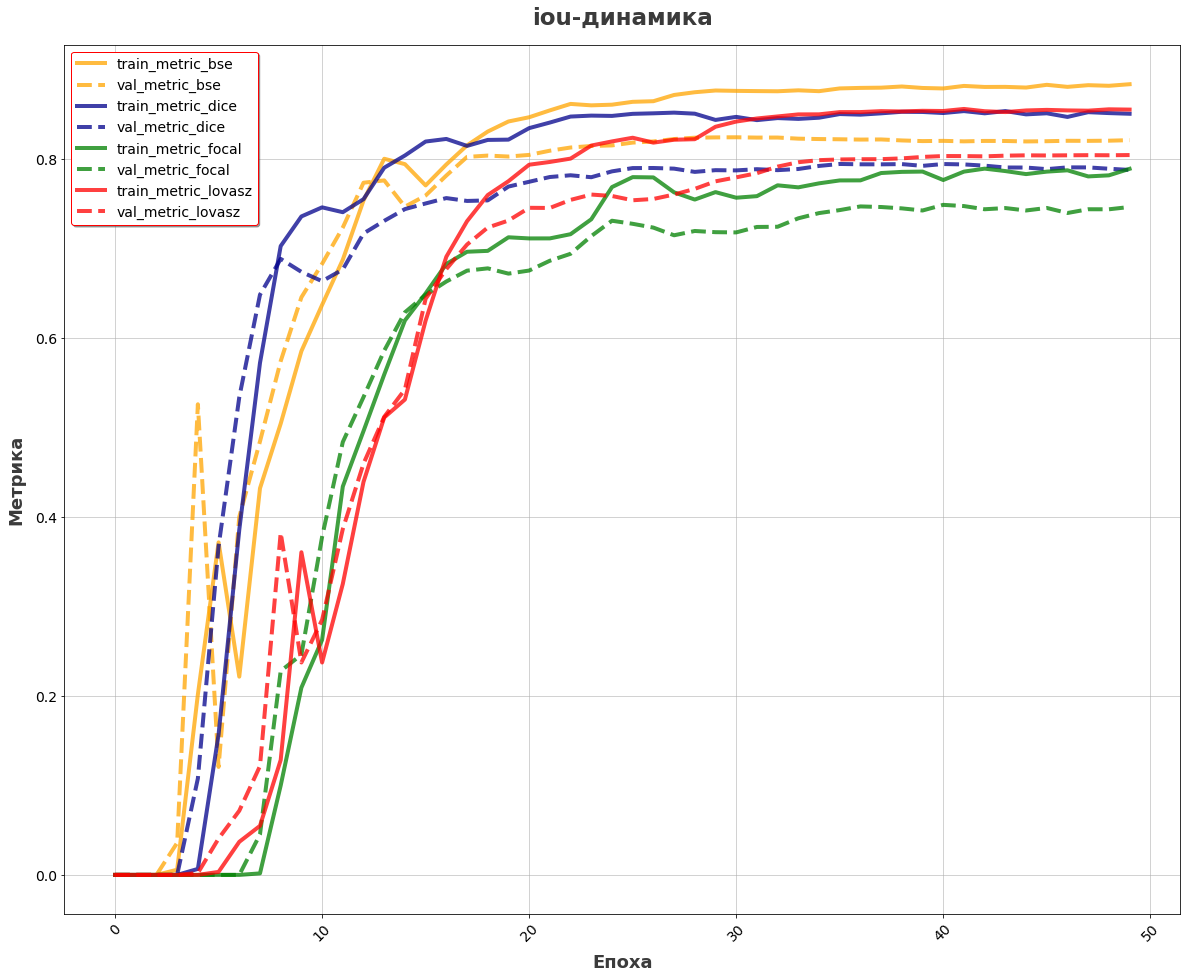

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse', 'dice', 'focal', 'lovasz']
colors = ['orange', 'darkblue', 'green', 'red']
metrics_iou = [bse_segnet_metric_e50, dice_segnet_metric_e50, focal_segnet_metric_e50, lovasz_segnet_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )


plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Как мы видим из графика наилучшие результаты на трайновой и валидационной выборке показывает архетиктура SegNet c bse_loss. Далее проверим остальные метрики

- Посчитаем метрик и лосы на тестовой выборке

In [ ]:
test_loss_bse, test_metic_bse = predict(model_bse, data_test, iou_pytorch, bse_loss)
test_loss_dice, test_metic_dice = predict(model_dice, data_test, iou_pytorch, dice_loss)
test_loss_focal, test_metic_focal = predict(model_focal, data_test, iou_pytorch, focal_loss)
test_loss_lovasz, test_metic_lovasz = predict(model_lovasz, data_test, iou_pytorch, lovasz_loss)

avg_test_loss: 0.144
avg_test_metric_score: 0.849


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


avg_test_loss: 0.196
avg_test_metric_score: 0.828
avg_test_loss: 0.041
avg_test_metric_score: 0.772
avg_test_loss: 0.299
avg_test_metric_score: 0.828


In [ ]:
df_final_segnet = pd.DataFrame({
    'test_loss': [test_loss_bse, test_loss_dice, test_loss_focal, test_loss_lovasz],
    'test_IOU': [test_metic_bse, test_metic_dice, test_metic_focal, test_metic_lovasz],
    'avg_time_train_epoch': [round(bse_segnet_time_train_e50.to_numpy().mean(),2), 
                             round(dice_segnet_time_train_e50.to_numpy().mean(),2),
                             round(focal_segnet_time_train_e50.to_numpy().mean(),2),
                             round(lovasz_segnet_time_train_e50.to_numpy().mean(),2),
                             ]
              }, index = ['bse', 'dice', 'focal', 'lovasz']         
)

display(df_final_segnet)

test_loss  test_IOU  avg_time_train_epoch
bse      0.144455  0.848898                 22.42
dice     0.196199  0.828299                 22.28
focal    0.040810  0.772252                 22.47
lovasz   0.299307  0.828025                 22.62

Из таблицы видно, что SegNet c bse_loss лоссом также показывает лучшие результаты на тестовой выборке, но не самое наименьшее среднее время обучение на одной эпохе. Наименьшее среднее время обучение на одной эпохе показывает SegNet c dice_loss

Давайте составим рейтинг архитектуры SegNet с различными лосами на основе метрики test_IOU

**1. SegNet с bse_loss**
2. SegNet c lovasz_loss
3. SegMet с dice_loss
4. SegNet 

**Вывод: в данной работе SegNet с bse_loss показала наилучшие результаты на тестовой выборке по метрике IOU среди архетиктур SegNet с различными лоссами, среднее время обучения на одну эпоху немного хуже чем у SegNet с dice_loss, однако отличие небольшое.**

- Сохраним результаты

In [ ]:
# df_final_segnet.to_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/df_final_segnet')

## UNet

- Загрузим модели

In [ ]:
model_unet_bse = UNet().to(device)
model_unet_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_e50.pth',map_location=torch.device('cpu')))

model_unet_dice = UNet().to(device)
model_unet_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_e50.pth',map_location=torch.device('cpu')))

model_unet_focal = UNet().to(device)
model_unet_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_e50.pth',map_location=torch.device('cpu')))

model_unet_lovasz = UNet().to(device)
model_unet_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_e50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

- Зашрузим лоссы и метрики

In [ ]:
unet_bse_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_loss_e50')
unet_bse_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_metric_e50')
unet_bse_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_time_train_e50')

unet_dice_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_loss_e50')
unet_dice_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_metric_e50')
unet_dice_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_dice_time_train_e50')

unet_focal_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_loss_e50')
unet_focal_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_metric_e50')
unet_focal_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_focal_time_train_e50')

unet_lovasz_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_loss_e50')
unet_lovasz_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_metric_e50')
unet_lovasz_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_lovasz_time_train_e50')

- Визуализируем метрики

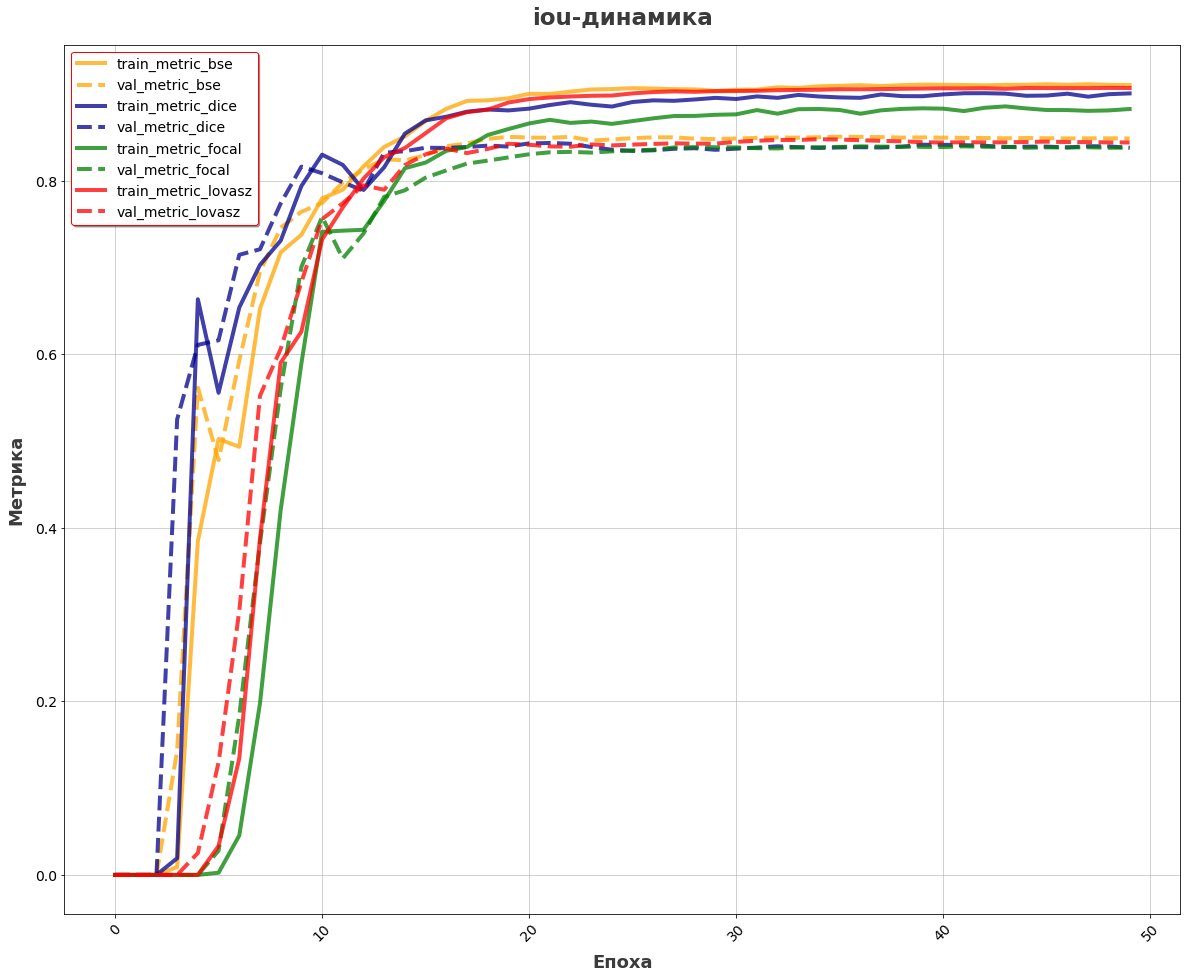

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse', 'dice', 'focal', 'lovasz']
colors = ['orange', 'darkblue', 'green', 'red']
metrics_iou = [unet_bse_metric_e50, unet_dice_metric_e50, unet_focal_metric_e50, unet_lovasz_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )


plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Из данного графика невозможно определить на каком loss модель показывается наилучшие результаты. Давайте построим график с измененным масштабом

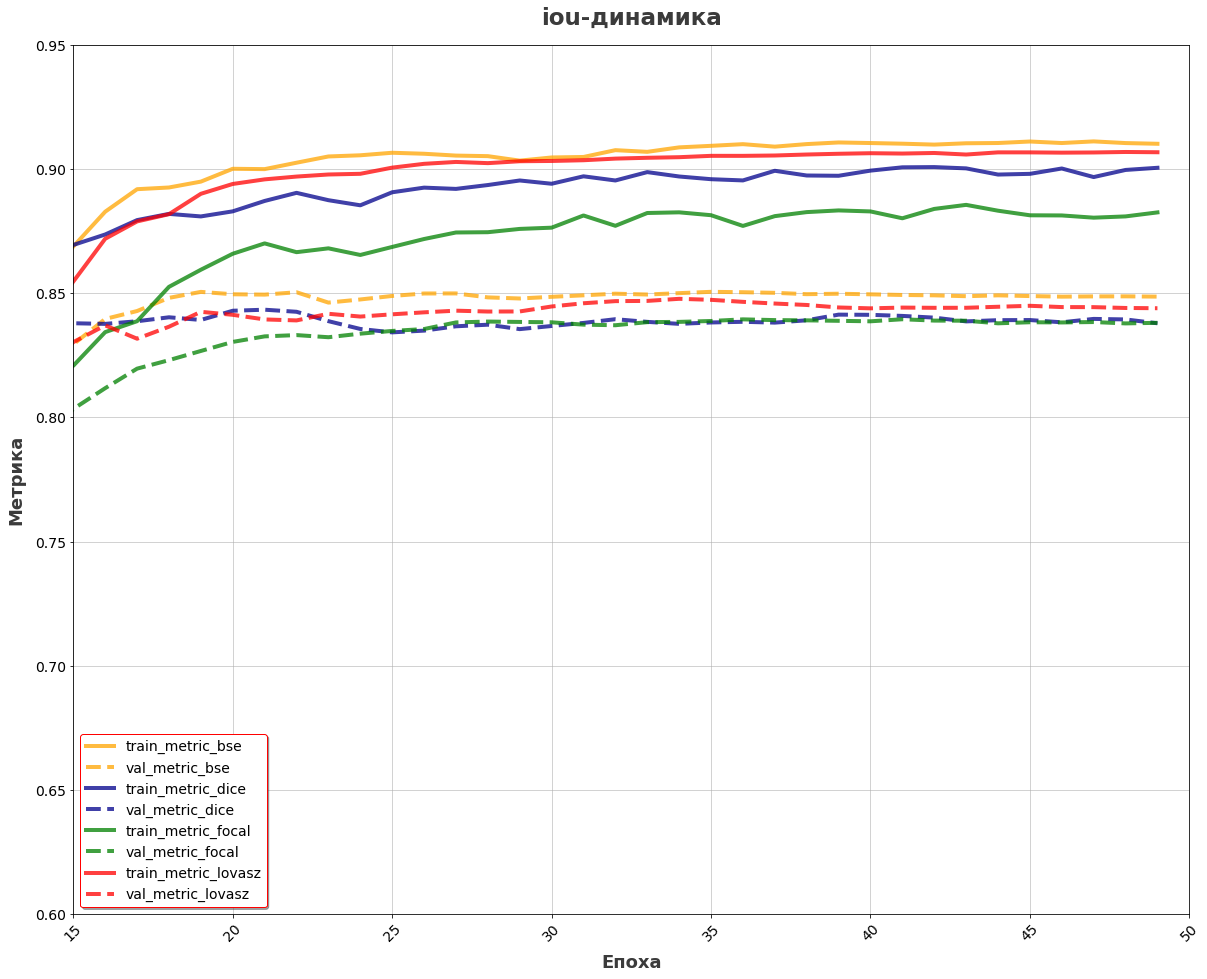

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse', 'dice', 'focal', 'lovasz']
colors = ['orange', 'darkblue', 'green', 'red']
metrics_iou = [unet_bse_metric_e50, unet_dice_metric_e50, unet_focal_metric_e50, unet_lovasz_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )

plt.xlim([15.,50])
plt.ylim([0.6, 0.95])
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Как мы видим из графика наилучшие результаты на трайновой и валидационной выборке показывает архетиктура UNEt c bse_loss. Далее проверим остальные метрики

- Посчитаем метрик и лосы на тестовой выборке

In [ ]:
test_loss_bse, test_metic_bse = predict(model_unet_bse, data_test, iou_pytorch, bse_loss)
test_loss_dice, test_metic_dice = predict(model_unet_dice, data_test, iou_pytorch, dice_loss)
test_loss_focal, test_metic_focal = predict(model_unet_focal, data_test, iou_pytorch, focal_loss)
test_loss_lovasz, test_metic_lovasz = predict(model_unet_lovasz, data_test, iou_pytorch, lovasz_loss)

avg_test_loss: 0.207
avg_test_metric_score: 0.876


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


avg_test_loss: 0.213
avg_test_metric_score: 0.875
avg_test_loss: 0.037
avg_test_metric_score: 0.851
avg_test_loss: 0.258
avg_test_metric_score: 0.868


In [ ]:
df_final_unet = pd.DataFrame({
    'test_loss': [test_loss_bse, test_loss_dice, test_loss_focal, test_loss_lovasz],
    'test_IOU': [test_metic_bse, test_metic_dice, test_metic_focal, test_metic_lovasz],
    'avg_time_train_epoch': [round(unet_bse_time_train_e50.to_numpy().mean(),2), 
                             round(unet_dice_time_train_e50.to_numpy().mean(),2),
                             round(unet_focal_time_train_e50.to_numpy().mean(),2),
                             round(unet_lovasz_time_train_e50.to_numpy().mean(),2),
                             ]
              }, index = ['bse', 'dice', 'focal', 'lovasz']         
)

display(df_final_unet)

test_loss  test_IOU  avg_time_train_epoch
bse      0.207107  0.876152                 29.93
dice     0.212786  0.874577                 30.78
focal    0.037178  0.850689                 30.16
lovasz   0.258497  0.867934                 30.20

In [ ]:
df_final_unet.style.highlight_max(color='green').highlight_min(color='orange')

Из таблицы видно, что UNet c bse_loss лоссом также показывает лучшие результаты на тестовой выборке, и при этом наименьшее среднее время обучение на одной эпохе.

Давайте составим рейтинг архитектуры UNet с различными лосами на основе метрики test_IOU

**1. UNet с bse_loss**
2. UNet c dice_loss
3. UMet с lovasz_loss
4. UNet c focal_loss

**Вывод: в данной работе UNet с bse_loss показала наилучшие результаты на тестовой выборке по метрике IOU среди архетиктур UgNet с различными лоссами, в дополнении среднее время обучения на одну эпоху оказалось наименьшим среди Unet-моделей с иными лосами.**

- Сохраним результаты

In [ ]:
# df_final_unet.to_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/df_final_unet')

## UNet2

- Загрузим модели

In [ ]:
model_unet2_bse = UNet2().to(device)
model_unet2_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_e50.pth',map_location=torch.device('cpu')))

model_unet2_dice = UNet2().to(device)
model_unet2_dice.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_e50.pth',map_location=torch.device('cpu')))

model_unet2_focal = UNet2().to(device)
model_unet2_focal.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_e50.pth',map_location=torch.device('cpu')))

model_unet2_lovasz = UNet2().to(device)
model_unet2_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_e50.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

- Зашрузим лоссы и метрики

In [ ]:
unet2_bse_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_loss_e50')
unet2_bse_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_metric_e50')
unet2_bse_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_bse_time_train_e50')

unet2_dice_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_loss_e50')
unet2_dice_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_metric_e50')
unet2_dice_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_dice_time_train_e50')

unet2_focal_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_loss_e50')
unet2_focal_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_metric_e50')
unet2_focal_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_focal_time_train_e50')

unet2_lovasz_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_loss_e50')
unet2_lovasz_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_metric_e50')
unet2_lovasz_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_time_train_e50')

- Визуализируем метрики

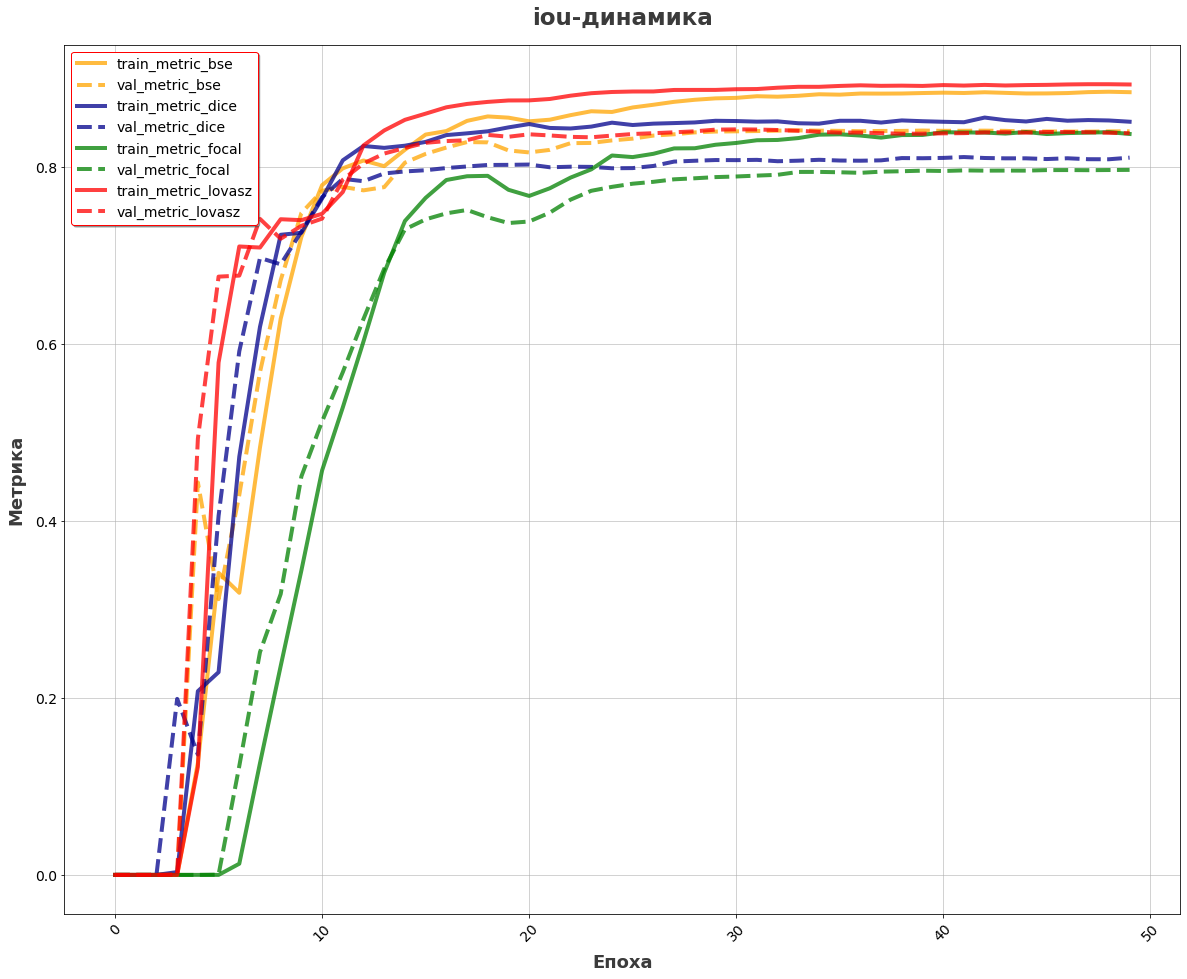

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse', 'dice', 'focal', 'lovasz']
colors = ['orange', 'darkblue', 'green', 'red']
metrics_iou = [unet2_bse_metric_e50, unet2_dice_metric_e50, unet2_focal_metric_e50, unet2_lovasz_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )


plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Из данного графика невозможно определить на каком loss модель показывается наилучшие результаты. Давайте построим график с измененным масштабом

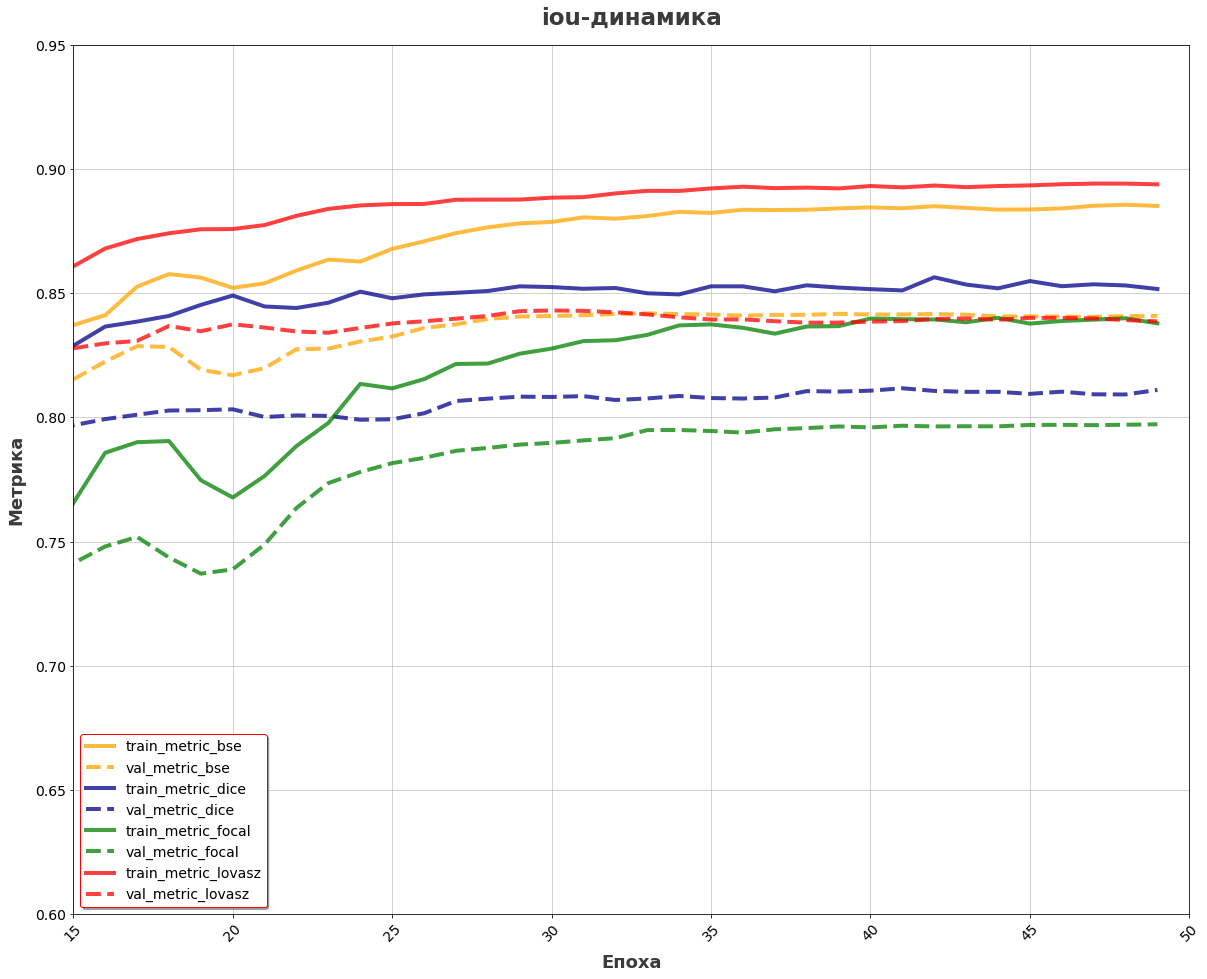

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse', 'dice', 'focal', 'lovasz']
colors = ['orange', 'darkblue', 'green', 'red']
metrics_iou = [unet2_bse_metric_e50, unet2_dice_metric_e50, unet2_focal_metric_e50, unet2_lovasz_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )

plt.xlim([15.,50])
plt.ylim([0.6, 0.95])
plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Как мы видим из графика не совсем какая Unet2-модель показывает наилучшие результаты на валидационной выборке - это либо Unet2 с bse_loss, либо Unet2 с lovasz_loss

- Посчитаем метрик и лосы на тестовой выборке

In [ ]:
test_loss_bse, test_metic_bse = predict(model_unet2_bse, data_test, iou_pytorch, bse_loss)
test_loss_dice, test_metic_dice = predict(model_unet2_dice, data_test, iou_pytorch, dice_loss)
test_loss_focal, test_metic_focal = predict(model_unet2_focal, data_test, iou_pytorch, focal_loss)
test_loss_lovasz, test_metic_lovasz = predict(model_unet2_lovasz, data_test, iou_pytorch, lovasz_loss)

avg_test_loss: 0.217
avg_test_metric_score: 0.867


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


avg_test_loss: 0.207
avg_test_metric_score: 0.842
avg_test_loss: 0.042
avg_test_metric_score: 0.809
avg_test_loss: 0.228
avg_test_metric_score: 0.874


In [ ]:
df_final_unet2 = pd.DataFrame({
    'test_loss': [test_loss_bse, test_loss_dice, test_loss_focal, test_loss_lovasz],
    'test_IOU': [test_metic_bse, test_metic_dice, test_metic_focal, test_metic_lovasz],
    'avg_time_train_epoch': [round(unet2_bse_time_train_e50.to_numpy().mean(),2), 
                             round(unet2_dice_time_train_e50.to_numpy().mean(),2),
                             round(unet2_focal_time_train_e50.to_numpy().mean(),2),
                             round(unet2_lovasz_time_train_e50.to_numpy().mean(),2),
                             ]
              }, index = ['bse', 'dice', 'focal', 'lovasz']         
)

display(df_final_unet2)

test_loss  test_IOU  avg_time_train_epoch
bse      0.216736  0.867200                 37.71
dice     0.207145  0.842053                 37.22
focal    0.041596  0.808852                 37.98
lovasz   0.227751  0.874178                 37.72

In [ ]:
df_final_unet2.style.highlight_max(color='green').highlight_min(color='orange')

Из таблицы видно, что UNet2 c lovasz_loss лоссом также показывает лучшие результаты на тестовой выборке, но не самое наименьшее среднее время обучение на одной эпохе. Наименьшее среднее время обучение на одной эпохе показывает UNet2 c dice_loss

Давайте составим рейтинг архитектуры UNet2 с различными лосами на основе метрики test_IOU

**1. UNet2 с lovasz_loss**
2. UNet2 c bse_loss
3. UMet2 с dice_loss
4. UNet2 c focal_loss

**Вывод: в данной работе UNet2 с lovasz_loss показала наилучшие результаты на тестовой выборке по метрике IOU среди архетиктур UNet2 с различными лоссами, среднее время обучения на одну эпоху немного хуже чем у UNet2 с dice_loss, однако отличие небольшое.**

- Сохраним результаты

In [ ]:
# df_final_unet2.to_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/df_final_unet2')

## Сравнение лучших моделей из каждой Архитектуры

- Загрузка моделей

In [ ]:
model_bse = SegNet()
model_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_e50.pth',map_location=torch.device('cpu')))

model_unet_bse = UNet().to(device)
model_unet_bse.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_e50.pth',map_location=torch.device('cpu')))

model_unet2_lovasz = UNet2().to(device)
model_unet2_lovasz.load_state_dict(torch.load('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_e50.pth',map_location=torch.device('cpu')))

- Загрузка лоссов и метрик

In [ ]:
bse_segnet_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_loss_e50')
bse_segnet_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_metric_e50')
bse_segnet_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/bse_segnet_time_train_e50')

unet_bse_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_loss_e50')
unet_bse_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_metric_e50')
unet_bse_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet_bse_time_train_e50')

unet2_lovasz_loss_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_loss_e50')
unet2_lovasz_metric_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_metric_e50')
unet2_lovasz_time_train_e50 = pd.read_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/unet2_lovasz_time_train_e50')

- Визуализируем метрики

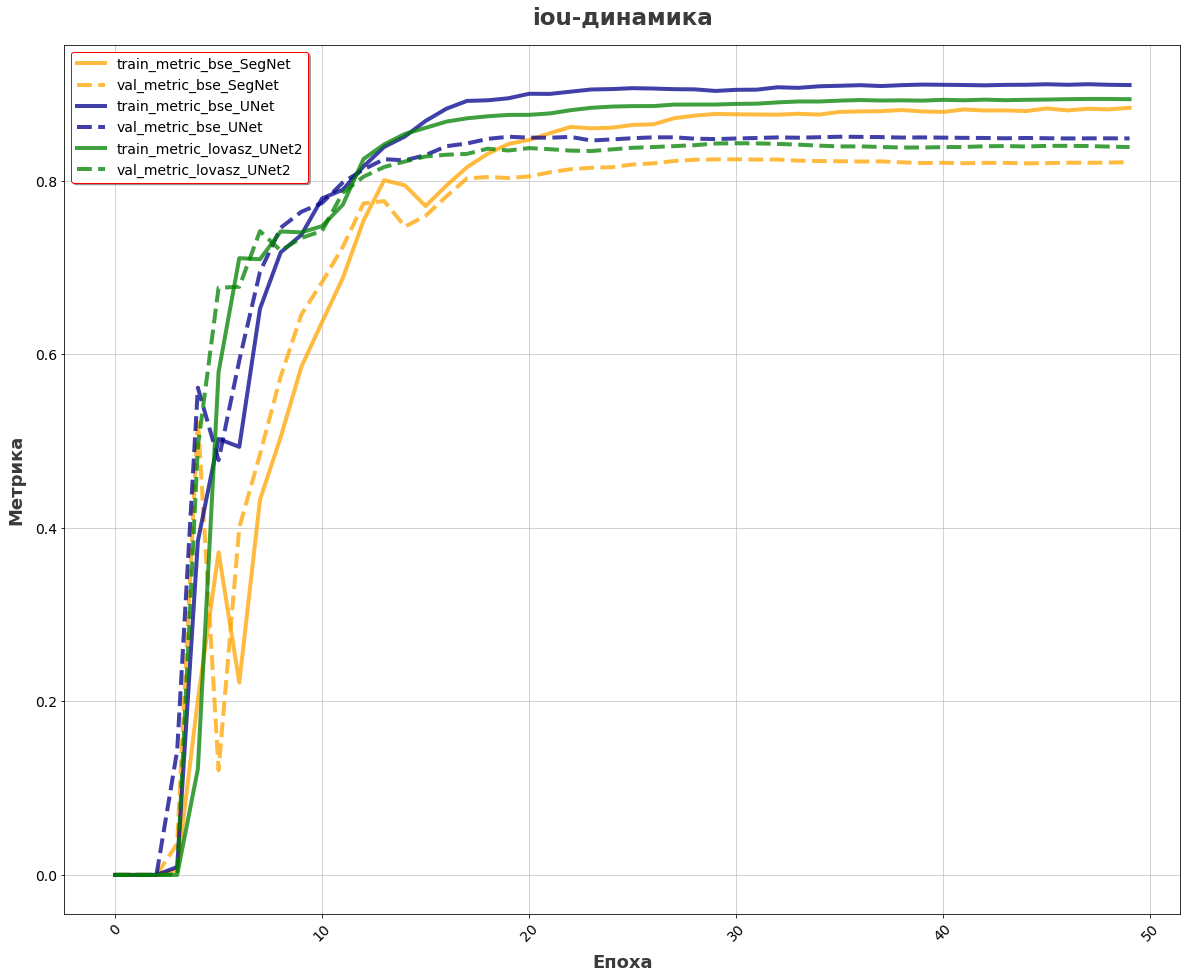

In [ ]:
plt.figure(figsize=(20, 16))

labels = ['bse_SegNet', 'bse_UNet', 'lovasz_UNet2']
colors = ['orange', 'darkblue', 'green']
metrics_iou = [bse_segnet_metric_e50, unet_bse_metric_e50, unet2_lovasz_metric_e50]

for metric_train_val, color, lbl in zip(metrics_iou, colors, labels):

    metric = metric_train_val.to_numpy()

    train_metric, val_metric = zip(*metric)

    plt.plot(
        train_metric, label='train_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='-', alpha=0.75
    ) 
    plt.plot(
        val_metric, label='val_metric' + '_' + lbl, linewidth=4, 
        color=color, linestyle='--', alpha=0.75
    )


plt.tick_params(axis='x', labelsize=14, 
                labelcolor='black', rotation=45)
plt.tick_params(axis='y', labelsize=14, 
                labelcolor='black')
plt.grid(True, alpha=0.7)


plt.legend(
        fontsize=14, shadow=True, framealpha=1, 
        facecolor='w', edgecolor='r', loc = 'best'
)
plt.xlabel(
        'Епоха', fontsize= 18, fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.ylabel(
        'Метрика', fontsize= 18 , fontweight = 600, labelpad = 10,
        color = 'black', alpha = 0.77
)
plt.title(
        'iou-динамика',fontsize = 23,
        fontweight = 700, pad = 20, color = 'black', alpha = 0.77
)
plt.show()

Как мы видим из графика наилучшие результаты на трайновой и валидационной выборке показывает архетиктура UNet c bse_loss. Далее проверим остальные метрики

- Посчитаем метрик и лосы на тестовой выборке

In [ ]:
segnet_bse_test_loss, segnet_bse_test_metic = predict(model_bse, data_test, iou_pytorch, bse_loss)
unet_bse_test_loss, unet_bse_test_metic = predict(model_unet_bse, data_test, iou_pytorch, bse_loss)
unet2_lovasz_test_loss, unet2_lovasz_test_metic = predict(model_unet2_lovasz, data_test, iou_pytorch, lovasz_loss)

avg_test_loss: 0.144
avg_test_metric_score: 0.849
avg_test_loss: 0.207
avg_test_metric_score: 0.876


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


avg_test_loss: 0.229
avg_test_metric_score: 0.874


In [ ]:
df_final = pd.DataFrame({
    'test_loss': [segnet_bse_test_loss, unet_bse_test_loss, unet2_lovasz_test_loss],
    'test_IOU': [segnet_bse_test_metic, unet_bse_test_metic, unet2_lovasz_test_metic],
    'avg_time_train_epoch': [round(bse_segnet_time_train_e50.to_numpy().mean(),2), 
                             round(unet_bse_time_train_e50.to_numpy().mean(),2),
                             round(unet2_lovasz_time_train_e50.to_numpy().mean(),2),
                             ]
              }, index = ['SegNet', 'UNet', 'UNet2']         
)

display(df_final)

test_loss  test_IOU  avg_time_train_epoch
SegNet   0.144455  0.848898                 22.42
UNet     0.207107  0.876153                 29.93
UNet2    0.228803  0.874178                 37.72

In [ ]:
df_final.style.highlight_max(color='green').highlight_min(color='orange')

**Вывод: Таким образом Unet c bse_loss оказывается наилучшей моделью в данной работе для сегментации медицинских снимков**

- Сохраним результаты

In [ ]:
# df_final.to_pickle('/content/drive/MyDrive/Course_stepic_NN/Segmentation/df_final')

## Заключение

- Модель которая показала наилучшие результаты на тестовой выборке по метрике IOU - UNet с bse_loss

- Наилучшая архитектура для задачи сегментации поражения кожи - UNet